# Duluth Complex code introduction

This notebook plots contains data analysis and visualization associated with the manuscript

Swanson-Hysell, N.L., Hoaglund, S.A., Crowley, J.L., Schmitz, M.D., Zhang, Y., and Miller Jr., J.D. (2020), **Rapid emplacement of the massive Duluth Complex intrusions within the Midcontinent Rift**, *Geology*



Corresponding Author: Nicholas L. Swanson-Hysell (swanson-hysell@berkeley.edu)

# Import scientific Python modules

In [1]:
import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib
import pmagpy.ipmag as ipmag

import mplstereonet

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Duluth Complex geochronology

New U-Pb dates developed from Duluth Complex and Beaver Bay Complex intrusive rocks can be compared to U-Pb dates developed from Midcontinent Rift volcanics and published in:

Swanson-Hysell, N.L., Ramenzani, J., Fairchild, L.M. and Rose, I., 2019, **Failed rifting and fast drifting: Midcontinent Rift development, Laurentia's rapid motion and the driver of Grenvillian orogenesis**, *Geological Society of America Bulletin*, doi:10.1130/B31944.1.

## Define function to generate date bar plot

In [2]:
def plot_dates(zircon_means, zircon_2sigmas, include, 
               sample_means, sample_2sigmas, colors, labels,
               legend=True, figsize=None, ylim=None, lineweight=None, 
               bbox_to_anchor=None, plot_zircons=True):
    """
    Make a date distribution plot.
    
    inputs:
    - zircon_means = list of numpy arrays containing mean dates (each array being a sample)
    - zircon_2sigmas = list of numpy arrays containing 2sigmas (each array being a sample)
    - include = list of 'yes' or 'no' array for inclusion in mean (each array being a sample)
    - sample_means = list of sample mean dates (one per sample)
    - sample_2sigmas = list of sample 2sigmas (one per sample)
    - colors = list of colors (one per sample)
    - labels = list of labels (one per sample)
    - figsize = figure size (optional)
    - ylim = ylim (optional)
    - linewidth = zircon linewidth (optional)
    - bbox_to_anchor = for the legend (optional)
    """
    # formatting constants
    zircon_spacing = 0.9
    sample_spacing = 5.75 - zircon_spacing
    start_x = 3
    yes_alpha = 0.8
    no_alpha = 0.2
    x_positions = []
    if lineweight==None:
        lineweight=3
    
    # initialize current x
    current_x = start_x
    
    # number of samples
    n_samples = len(zircon_means)
    
    # plot
    if figsize == None:
        fig, ax = plt.subplots()
    else:
        fig, ax = plt.subplots(figsize=figsize)
    
    if plot_zircons == False:
        for i in range(n_samples):
            sample_width = 20

            rectangle = matplotlib.patches.Rectangle((current_x-1, sample_means[i]-sample_2sigmas[i]),\
                                                     sample_width+1, sample_2sigmas[i]*2, color='lightgrey')
            ax.add_patch(rectangle)

            # the mean age

            ax.hlines(sample_means[i], current_x-1, current_x+sample_width)
            
            current_x = current_x + 25
        
    if plot_zircons == True:
        # iterate over each sample
        for i in range(n_samples):

            # number of zircons in sample
            n_zircons = len(zircon_means[i])

            # sample width
            sample_width = zircon_spacing*n_zircons

            rectangle = matplotlib.patches.Rectangle((current_x-1, sample_means[i]-sample_2sigmas[i]),\
                                                     sample_width+1, sample_2sigmas[i]*2, color='lightgrey')
            ax.add_patch(rectangle)

            # the mean age

            ax.hlines(sample_means[i], current_x-1, current_x+sample_width)

            # legend control
            marked = False

            # iterate over each zircon
            for j in range(n_zircons):

                if marked:
                    if include[i][j] == 'yes':
                        ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                                  colors=colors[i], lw=lineweight, alpha=yes_alpha)
                    else:
                        ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                                  colors=colors[i], lw=lineweight, alpha=no_alpha)
                else:
                    if include[i][j] == 'yes':
                        ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                                  colors=colors[i], lw=lineweight, alpha=yes_alpha, label=labels[i])
                        marked = True
                    else:
                        ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                                  colors=colors[i], lw=lineweight, alpha=no_alpha)

                # tick the x to the next zircon
                current_x = current_x + zircon_spacing

            # tick the x to the next sample
            current_x = current_x + sample_spacing
            x_positions.append(current_x-sample_spacing)
    
    # prettify
    ax.invert_yaxis()
    ax.set_ylabel('$^{206}$Pb/$^{238}$U date (Ma)',fontsize=13)
    if legend == True:
        if bbox_to_anchor == None:
            ax.legend(bbox_to_anchor=(1.8,1), fontsize=12)
        else:
            ax.legend(bbox_to_anchor=bbox_to_anchor, fontsize=12)
    if ylim != None:
        ax.set_ylim(ylim)
        
    return fig, ax, x_positions

In [3]:
def weighted_mean(dates,sigma):
    
    """
    calculated a weighted mean from dates and uncertainities
    
    input parameters
    ----------------
    dates: date of individual grains
    sigma: 1σ uncertainty associated with dates
    
    returns
    ----------------
    weighted_mean, 1σ uncertainty
    
    """
    
    inverse_variance=[]
    alpha=[]
    weighted_mean_calc=[]
    
    for n in range(0,len(dates)):
        value = 1/sigma[n]**2
        inverse_variance.append(value)
    inverse_variance_sum = np.sum(inverse_variance)
    
    for n in range(0,len(dates)):
        value = (1/sigma[n]**2)/inverse_variance_sum
        alpha.append(value)
        
    #calculate the weights for each date    
    for n in range(0,len(dates)):
        value = alpha[n]*dates[n]
        weighted_mean_calc.append(value)
    
    #take the sum of the weights multiplied by the dates to get the weighted
    #mean (equation 64 of McLean et al., 2011)
    weighted_mean = np.sum(weighted_mean_calc)
    
    #the variance of the weighted mean is simply the inverse of the sum of
    #the inverse variances of each date (equation 66 of McLean et al., 2011)
    variance = 1/inverse_variance_sum
    
    weighted_mean_sigma = np.sqrt(variance)
    
    n = len(dates)
    
    print('The weighted mean is:')

    print(weighted_mean)

    print('With a 2sigma error of:')

    print(weighted_mean_sigma)
    
    print('N=' )
    print(n)
    
    return weighted_mean, weighted_mean_sigma

## Import individual zircon dates for the date bar plot

### PRI

In [4]:
PRI = pd.read_excel('../data/geochron_new/CAIDTIMS_DataTable_080420.xls',
                      header=6,nrows=6,names=['zircon','Th_U','206Pb_mol','206Pb_mol%','Pb*/Pbc',
                                              'Pbc','206Pb/204Pb','','','','','','','','','','',
                                              '207Pb/206Pb_date','207Pb/206Pb_date_2sigma',
                                              '207Pb/235U_date','207Pb/235U_date_2sigma',
                                              '206Pb/238U_date','206Pb/238U_date_2sigma'])
PRI['include'] = pd.Series(data=['yes','yes','yes','yes','yes','yes'])
PRI

,zircon,Th_U,206Pb_mol,206Pb_mol%,Pb*/Pbc,Pbc,206Pb/204Pb,,.1,.2,.3,.4,.5,.6,.7,.8,.9,207Pb/206Pb_date,207Pb/206Pb_date_2sigma,207Pb/235U_date,207Pb/235U_date_2sigma,206Pb/238U_date,206Pb/238U_date_2sigma,include
0,z2,0.665204,20.738831,0.999465,598.997048,0.912757,34763.091318,NaN,0.201468,0.076115,0.042027,1.945654,0.084024,0.185393,0.045037,0.967479,NaN,1098.100543,0.840968,1096.949502,0.563532,1096.369296,0.454065,yes
1,z5,0.795390,15.370751,0.999298,470.376992,0.888256,26480.058244,NaN,0.240897,0.076087,0.041746,1.944886,0.083922,0.185388,0.044575,0.974036,NaN,1097.367406,0.835439,1096.684811,0.562770,1096.341199,0.449398,yes
2,z1,0.714043,21.496997,0.999219,414.920581,1.381772,23808.791473,NaN,0.216261,0.076084,0.043480,1.944671,0.085307,0.185375,0.045624,0.959467,NaN,1097.285151,0.870142,1096.610856,0.572040,1096.271661,0.459944,yes
3,z6,0.624498,12.483620,0.999191,391.978441,0.831426,22978.687310,NaN,0.189143,0.076096,0.038926,1.944592,0.083271,0.185339,0.045191,0.991360,NaN,1097.592711,0.778968,1096.583583,0.558374,1096.075160,0.455501,yes
4,z4,0.609620,11.022847,0.998837,271.821434,1.054866,15997.732443,NaN,0.184637,0.076106,0.045346,1.944827,0.087321,0.185336,0.046494,0.952037,NaN,1097.868085,0.907422,1096.664479,0.585555,1096.058666,0.468634,yes
5,z3,0.668869,4.580803,0.998332,192.103651,0.629200,11151.532746,NaN,0.202582,0.076132,0.055232,1.945424,0.094024,0.185329,0.047827,0.898106,NaN,1098.551154,1.105137,1096.870480,0.630570,1096.024042,0.482057,yes


In [5]:
PRI_mean, PRI_2sigma = weighted_mean(PRI['206Pb/238U_date'].tolist(),PRI['206Pb/238U_date_2sigma'].tolist())

The weighted mean is:
1096.1949149677969
With a 2sigma error of:
0.18829360877861095
N=
6


In [6]:
weighted_mean(PRI['207Pb/206Pb_date'].tolist(),PRI['207Pb/206Pb_date_2sigma'].tolist())

The weighted mean is:
1097.7339098613106
With a 2sigma error of:
0.3569444447827721
N=
6


(1097.7339098613106, 0.3569444447827721)

### FC4b

In [7]:
FC_4b = pd.read_excel('../data/geochron_new/CAIDTIMS_DataTable_080420.xls',
                      header=16,nrows=8,names=['zircon','Th_U','206Pb_mol','206Pb_mol%','Pb*/Pbc',
                                              'Pbc','206Pb/204Pb','','','','','','','','','','',
                                              '207Pb/206Pb_date','207Pb/206Pb_date_2sigma',
                                              '207Pb/235U_date','207Pb/235U_date_2sigma',
                                              '206Pb/238U_date','206Pb/238U_date_2sigma'])
FC_4b['include'] = pd.Series(data=['yes','yes','yes','yes','yes','yes','yes','no'])
FC_4b

,zircon,Th_U,206Pb_mol,206Pb_mol%,Pb*/Pbc,Pbc,206Pb/204Pb,,.1,.2,.3,.4,.5,.6,.7,.8,.9,207Pb/206Pb_date,207Pb/206Pb_date_2sigma,207Pb/235U_date,207Pb/235U_date_2sigma,206Pb/238U_date,206Pb/238U_date_2sigma,include
0,z10,0.732493,8.741441,0.998602,232.714287,1.006159,13303.954512,NaN,0.221854,0.076063,0.047200,1.943304,0.088769,0.185297,0.046514,0.946454,NaN,1096.720099,0.944684,1096.139375,0.595111,1095.846192,0.468752,yes
1,z2,0.685956,30.215754,0.999553,720.872893,1.110498,41626.178163,NaN,0.207760,0.076108,0.041134,1.944432,0.084174,0.185295,0.046232,0.967581,NaN,1097.903848,0.823122,1096.528319,0.564413,1095.835821,0.465909,yes
2,z4,0.705346,20.983914,0.999470,610.239491,0.915220,35079.063942,NaN,0.213633,0.076103,0.041576,1.944131,0.085021,0.185277,0.047189,0.962973,NaN,1097.785830,0.831979,1096.424420,0.570068,1095.738377,0.475511,yes
3,z11,0.716248,11.751073,0.998873,287.658581,1.090072,16503.217227,NaN,0.216936,0.076093,0.045205,1.943756,0.087111,0.185266,0.046228,0.953820,NaN,1097.514033,0.904642,1096.295173,0.584039,1095.680882,0.465806,yes
4,z3,0.637369,48.508804,0.999751,1280.248927,0.992261,74775.472679,NaN,0.193046,0.076115,0.040481,1.944305,0.086180,0.185265,0.050644,0.956941,NaN,1098.089814,0.810031,1096.484558,0.577856,1095.675321,0.510301,yes
5,z1,0.630074,18.180244,0.999420,547.799730,0.867566,32063.117209,NaN,0.190837,0.076078,0.041777,1.943210,0.084107,0.185251,0.045221,0.969363,NaN,1097.117066,0.836080,1096.106997,0.563848,1095.599212,0.455627,yes
6,z6,0.658618,12.040454,0.999194,396.896589,0.798492,23076.985734,NaN,0.199484,0.076086,0.043555,1.943138,0.086468,0.185223,0.047401,0.954788,NaN,1097.342372,0.871633,1096.081885,0.579669,1095.447828,0.477528,yes
7,z5,0.466824,9.685236,0.998807,255.684352,0.951335,15586.620064,NaN,0.141401,0.076159,0.045771,1.943271,0.087635,0.185060,0.046373,0.951710,NaN,1099.241376,0.915732,1096.128026,0.587506,1094.561151,0.466827,no


In [8]:
FC_4b_filtered = FC_4b[FC_4b['include'] == 'yes']
FC4b_mean, FC4b_2sigma = weighted_mean(FC_4b_filtered['206Pb/238U_date'].tolist(),FC_4b_filtered['206Pb/238U_date_2sigma'].tolist())

The weighted mean is:
1095.68996253492
With a 2sigma error of:
0.17893748108450228
N=
7


In [9]:
weighted_mean(FC_4b_filtered['207Pb/206Pb_date'].tolist(),FC_4b_filtered['207Pb/206Pb_date_2sigma'].tolist())

The weighted mean is:
1097.531031573214
With a 2sigma error of:
0.3238648206769041
N=
7


(1097.531031573214, 0.3238648206769041)

### FC1

In [10]:
FC_1 = pd.read_excel('../data/geochron_new/CAIDTIMS_DataTable_080420.xls',
                      header=28,nrows=10,names=['zircon','Th_U','206Pb_mol','206Pb_mol%','Pb*/Pbc',
                                              'Pbc','206Pb/204Pb','','','','','','','','','','',
                                              '207Pb/206Pb_date','207Pb/206Pb_date_2sigma',
                                              '207Pb/235U_date','207Pb/235U_date_2sigma',
                                              '206Pb/238U_date','206Pb/238U_date_2sigma'])
FC_1['include'] = pd.Series(data=['yes','yes','yes','yes','yes','yes','yes','yes','yes','yes','yes'])
FC_1

,zircon,Th_U,206Pb_mol,206Pb_mol%,Pb*/Pbc,Pbc,206Pb/204Pb,,.1,.2,.3,.4,.5,.6,.7,.8,.9,207Pb/206Pb_date,207Pb/206Pb_date_2sigma,207Pb/235U_date,207Pb/235U_date_2sigma,206Pb/238U_date,206Pb/238U_date_2sigma,include
0,z21,0.346609,89.347895,0.999927,4054.676586,0.536709,254585.737618,NaN,0.104978,0.076114,0.040011,1.945436,0.085824,0.185375,0.050673,0.957982,NaN,1098.075509,0.800634,1096.874461,0.575582,1096.269262,0.510845,yes
1,z23,1.361833,38.675195,0.999810,1968.511425,0.604166,97907.295233,NaN,0.412450,0.076128,0.040295,1.945645,0.085729,0.185360,0.050131,0.958654,NaN,1098.447442,0.806270,1096.946443,0.574965,1096.190626,0.505346,yes
2,z22,0.614343,135.133318,0.999962,8331.540030,0.422393,489236.023246,NaN,0.186069,0.076095,0.039946,1.944341,0.085691,0.185317,0.050545,0.958392,NaN,1097.564101,0.799394,1096.496987,0.574579,1095.959045,0.509420,yes
3,z26,1.443480,63.568766,0.999918,4619.958647,0.430198,225978.970327,NaN,0.437182,0.076115,0.040037,1.944854,0.084192,0.185317,0.047834,0.965270,NaN,1098.093390,0.801159,1096.673976,0.564577,1095.958878,0.482097,yes
4,z20,1.508076,98.565374,0.999919,4740.478757,0.658544,228892.387686,NaN,0.456746,0.076133,0.040032,1.945290,0.093168,0.185315,0.062308,0.944068,NaN,1098.561883,0.800995,1096.824143,0.624818,1095.947910,0.627970,yes
5,z25,0.684380,41.109875,0.999849,2138.855734,0.509040,123513.915634,NaN,0.207283,0.076130,0.040198,1.944934,0.083452,0.185289,0.046252,0.969964,NaN,1098.479629,0.804322,1096.701475,0.559626,1095.806250,0.466096,yes
6,z19,0.715076,125.901073,0.999941,5523.148853,0.608119,316608.663227,NaN,0.216582,0.076125,0.039978,1.944464,0.085099,0.185255,0.049487,0.960828,NaN,1098.368764,0.799938,1096.539480,0.570621,1095.618115,0.498619,yes
7,z27,0.546654,56.258525,0.999807,1613.937040,0.892957,96360.365426,NaN,0.165571,0.076142,0.040389,1.944896,0.083699,0.185254,0.046503,0.968172,NaN,1098.819375,0.808107,1096.688323,0.561273,1095.615267,0.468548,yes
8,z18,1.413612,46.240978,0.999797,1865.096833,0.770490,91791.963200,NaN,0.428148,0.076104,0.040343,1.943656,0.084305,0.185230,0.047599,0.965248,NaN,1097.800136,0.807306,1096.260529,0.565219,1095.485328,0.479545,yes
9,z24,1.439475,92.317512,0.999944,6768.172748,0.426115,331312.986492,NaN,0.435984,0.076107,0.039986,1.943493,0.084925,0.185206,0.049194,0.961596,NaN,1097.900271,0.800155,1096.204372,0.569359,1095.351315,0.495552,yes


In [11]:
FC1_mean, FC1_2sigma = weighted_mean(FC_1['206Pb/238U_date'].tolist(),FC_1['206Pb/238U_date_2sigma'].tolist())

The weighted mean is:
1095.8064839177662
With a 2sigma error of:
0.15803362004300317
N=
10


In [12]:
weighted_mean(FC_1['207Pb/206Pb_date'].tolist(),FC_1['207Pb/206Pb_date_2sigma'].tolist())

The weighted mean is:
1098.209797887362
With a 2sigma error of:
0.253870607708266
N=
10


(1098.209797887362, 0.253870607708266)

### BEI

In [13]:
BEI = pd.read_excel('../data/geochron_new/CAIDTIMS_DataTable_080420.xls',
                      header=42,nrows=6,names=['zircon','Th_U','206Pb_mol','206Pb_mol%','Pb*/Pbc',
                                              'Pbc','206Pb/204Pb','','','','','','','','','','',
                                              '207Pb/206Pb_date','207Pb/206Pb_date_2sigma',
                                              '207Pb/235U_date','207Pb/235U_date_2sigma',
                                              '206Pb/238U_date','206Pb/238U_date_2sigma'])
BEI['include'] = pd.Series(data=['yes','yes','yes','yes','yes','yes'])
BEI

,zircon,Th_U,206Pb_mol,206Pb_mol%,Pb*/Pbc,Pbc,206Pb/204Pb,,.1,.2,.3,.4,.5,.6,.7,.8,.9,207Pb/206Pb_date,207Pb/206Pb_date_2sigma,207Pb/235U_date,207Pb/235U_date_2sigma,206Pb/238U_date,206Pb/238U_date_2sigma,include
0,z4,0.680513,16.166279,0.999059,341.789128,1.251490,19771.884380,NaN,0.206107,0.076097,0.043677,1.944811,0.085082,0.185357,0.044485,0.965728,NaN,1097.621322,0.874051,1096.659031,0.570539,1096.174776,0.448424,yes
1,z6a,0.648842,30.114618,0.999651,914.282088,0.864928,53260.553285,NaN,0.196517,0.076078,0.045237,1.944074,0.085445,0.185332,0.045499,0.942047,NaN,1097.131371,0.905329,1096.404753,0.572900,1096.038809,0.458593,yes
2,z6b,0.841343,24.905968,0.999584,803.433314,0.851613,44740.242394,NaN,0.254820,0.076081,0.039295,1.944010,0.084195,0.185319,0.047651,0.974037,NaN,1097.210050,0.786410,1096.382906,0.564514,1095.966354,0.480253,yes
3,z5,0.651769,4.752472,0.998288,186.418528,0.669905,10866.936150,NaN,0.197405,0.076062,0.049568,1.943397,0.090414,0.185308,0.046029,0.941509,NaN,1096.695065,0.992072,1096.171437,0.606148,1095.907372,0.463888,yes
4,z3,0.575568,6.727079,0.998244,178.375718,0.972931,10591.668848,NaN,0.174326,0.076104,0.051975,1.944330,0.091373,0.185294,0.045535,0.927870,NaN,1097.810864,1.040079,1096.493129,0.612679,1095.829451,0.458877,yes
5,z1,0.522555,5.978246,0.998057,159.135870,0.956634,9574.788902,NaN,0.158275,0.076119,0.053582,1.943668,0.094764,0.185195,0.049545,0.911999,NaN,1098.193526,1.072177,1096.264721,0.635342,1095.292982,0.499063,yes


In [14]:
BEI_mean, BEI_2sigma = weighted_mean(BEI['206Pb/238U_date'].tolist(),BEI['206Pb/238U_date_2sigma'].tolist())

The weighted mean is:
1095.8845755325888
With a 2sigma error of:
0.19078005572414714
N=
6


In [15]:
weighted_mean(BEI['207Pb/206Pb_date'].tolist(),BEI['207Pb/206Pb_date_2sigma'].tolist())

The weighted mean is:
1097.4012446817937
With a 2sigma error of:
0.37914805982744265
N=
6


(1097.4012446817937, 0.37914805982744265)

### HCT

In [16]:
HCT = pd.read_excel('../data/geochron_new/CAIDTIMS_DataTable_080420.xls',
                      header=52,nrows=11,names=['zircon','Th_U','206Pb_mol','206Pb_mol%','Pb*/Pbc',
                                              'Pbc','206Pb/204Pb','','','','','','','','','','',
                                              '207Pb/206Pb_date','207Pb/206Pb_date_2sigma',
                                              '207Pb/235U_date','207Pb/235U_date_2sigma',
                                              '206Pb/238U_date','206Pb/238U_date_2sigma'])
HCT['include'] = pd.Series(data=['yes','yes','yes','yes','no','no','no','no','no','no','no'])
HCT

,zircon,Th_U,206Pb_mol,206Pb_mol%,Pb*/Pbc,Pbc,206Pb/204Pb,,.1,.2,.3,.4,.5,.6,.7,.8,.9,207Pb/206Pb_date,207Pb/206Pb_date_2sigma,207Pb/235U_date,207Pb/235U_date_2sigma,206Pb/238U_date,206Pb/238U_date_2sigma,include
0,z7,0.764721,11.693407,0.997795,148.590148,2.124054,8437.048906,NaN,0.231617,0.076148,0.054816,1.945126,0.094359,0.185263,0.046349,0.920022,NaN,1098.958850,1.096735,1096.767700,0.632785,1095.664310,0.467016,yes
1,z6,0.665971,4.761950,0.996835,101.024775,1.242870,5877.497309,NaN,0.201709,0.076088,0.066774,1.943504,0.106356,0.185254,0.051201,0.869933,NaN,1097.388864,1.336291,1096.208325,0.713036,1095.613548,0.515880,yes
2,z1,0.395540,3.702192,0.994501,54.247538,1.683118,3382.175294,NaN,0.119804,0.076008,0.099011,1.940861,0.138646,0.185196,0.059801,0.783685,NaN,1095.293164,1.982058,1095.296299,0.929091,1095.297235,0.602377,yes
3,z10,0.719092,3.506297,0.996543,93.626752,1.000012,5380.271803,NaN,0.217804,0.076115,0.069366,1.943201,0.108273,0.185159,0.050520,0.865074,NaN,1098.100543,1.388030,1096.103683,0.725851,1095.098899,0.508801,yes
4,z4,1.566024,1.317539,0.987617,31.077112,1.358191,1502.003580,NaN,0.474332,0.076022,0.209560,1.939747,0.255769,0.185058,0.082579,0.670508,NaN,1095.640063,4.194906,1094.911430,1.713616,1094.545660,0.831297,no
5,z9,1.053099,4.869438,0.997980,173.136262,0.810178,9209.435293,NaN,0.318984,0.076086,0.053514,1.940680,0.093928,0.184991,0.047531,0.920446,NaN,1097.328067,1.070960,1095.233677,0.629408,1094.181048,0.478328,no
6,z12,1.398374,4.797283,0.997744,166.661643,0.891787,8244.640101,NaN,0.423571,0.076078,0.056917,1.939859,0.097822,0.184932,0.050157,0.901529,NaN,1097.117066,1.139100,1094.950120,0.655408,1093.860042,0.504628,no
7,z11,0.687422,2.186194,0.994740,60.962741,0.950404,3536.123144,NaN,0.208227,0.076054,0.096413,1.939117,0.134773,0.184918,0.056470,0.792135,NaN,1096.498370,1.929697,1094.693930,0.902862,1093.786140,0.568103,no
8,z14,0.403788,1.060983,0.995127,61.392763,0.427131,3817.030070,NaN,0.122313,0.076053,0.085643,1.938838,0.233250,0.184895,0.202313,0.932421,NaN,1096.462607,1.714137,1094.597559,1.562490,1093.659915,2.035108,no
9,z8,2.079234,1.584600,0.992583,57.415270,0.973467,2507.772918,NaN,0.629813,0.076134,0.128243,1.940092,0.246596,0.184818,0.191170,0.858150,NaN,1098.583341,2.566016,1095.030500,1.652254,1093.244146,1.922347,no


In [17]:
HCT_filtered = HCT[HCT['include'] == 'yes']
HCT_mean, HCT_2sigma = weighted_mean(HCT_filtered['206Pb/238U_date'].tolist(),HCT_filtered['206Pb/238U_date_2sigma'].tolist())

The weighted mean is:
1095.4379621556755
With a 2sigma error of:
0.25853320335225466
N=
4


In [18]:
weighted_mean(HCT['207Pb/206Pb_date'].tolist(),HCT['207Pb/206Pb_date_2sigma'].tolist())

The weighted mean is:
1097.428102936908
With a 2sigma error of:
0.4596197147877392
N=
11


(1097.428102936908, 0.4596197147877392)

### WLFG

In [19]:
WLFG = pd.read_excel('../data/geochron_new/CAIDTIMS_DataTable_080420.xls',
                      header=67,nrows=8,names=['zircon','Th_U','206Pb_mol','206Pb_mol%','Pb*/Pbc',
                                              'Pbc','206Pb/204Pb','','','','','','','','','','',
                                              '207Pb/206Pb_date','207Pb/206Pb_date_2sigma',
                                              '207Pb/235U_date','207Pb/235U_date_2sigma',
                                              '206Pb/238U_date','206Pb/238U_date_2sigma'])
WLFG['include'] = pd.Series(data=['yes','yes','yes','yes','yes','no','no','no'])
WLFG

,zircon,Th_U,206Pb_mol,206Pb_mol%,Pb*/Pbc,Pbc,206Pb/204Pb,,.1,.2,.3,.4,.5,.6,.7,.8,.9,207Pb/206Pb_date,207Pb/206Pb_date_2sigma,207Pb/235U_date,207Pb/235U_date_2sigma,206Pb/238U_date,206Pb/238U_date_2sigma,include
0,z2,1.224601,3.644101,0.996738,111.063300,0.980568,5701.490862,NaN,0.370977,0.075967,0.066129,1.933162,0.105049,0.184562,0.049038,0.880164,NaN,1094.195247,1.324029,1092.634480,0.703000,1091.851709,0.492535,yes
1,z9,1.236322,1.201512,0.980587,18.408557,1.955569,958.131961,NaN,0.374529,0.076083,0.312266,1.936035,0.382628,0.184555,0.134461,0.650878,NaN,1097.249389,6.249326,1093.628513,2.561876,1091.809997,1.350467,yes
2,z16,1.208902,0.771680,0.987189,27.918931,0.823318,1451.864318,NaN,0.366226,0.075998,0.204605,1.933520,0.265114,0.184521,0.114071,0.685053,NaN,1095.021367,4.096086,1092.758355,1.774281,1091.623287,1.145497,yes
3,z26,1.115325,1.319440,0.992252,45.477806,0.847075,2400.504923,NaN,0.337884,0.075943,0.130765,1.931614,0.171326,0.184473,0.064427,0.743102,NaN,1093.562245,2.618404,1092.098518,1.146214,1091.364092,0.646834,yes
4,z19,2.350041,0.398676,0.971479,15.320475,0.962260,652.153967,NaN,0.711935,0.076052,0.418774,1.933129,0.516889,0.184353,0.154665,0.723818,NaN,1096.437573,8.381948,1092.622947,3.459052,1090.710440,1.551951,yes
5,z27,2.409834,0.711368,0.981585,24.219815,1.097206,1010.030685,NaN,0.730155,0.076019,0.289893,1.927110,0.351124,0.183859,0.109579,0.666186,NaN,1095.564961,5.803091,1090.537132,2.347244,1088.021503,1.097062,no
6,z28,1.612990,0.467551,0.981962,21.409403,0.706115,1031.134181,NaN,0.488775,0.075879,0.298321,1.920473,0.392827,0.183562,0.193654,0.675796,NaN,1091.892123,5.975028,1088.232224,2.622925,1086.404666,1.936135,no
7,z18,1.209867,0.241141,0.958630,8.396053,0.855564,449.597663,NaN,0.366629,0.075685,0.693197,1.915054,0.825942,0.183513,0.265967,0.619990,NaN,1086.763740,13.894494,1086.346592,5.509521,1086.138700,2.658519,no


In [20]:
WLFG_filtered = WLFG[WLFG['include'] == 'yes']
WLFG_mean, WLFG_2sigma = weighted_mean(WLFG_filtered['206Pb/238U_date'].tolist(),WLFG_filtered['206Pb/238U_date_2sigma'].tolist())

The weighted mean is:
1091.6288060423644
With a 2sigma error of:
0.34841171503396046
N=
5


### Import data from MCR intrusives and volcanics from other studies

In [21]:
AS3 = pd.read_csv('../data/geochron_published/AS3_dates.csv')
AS3.sort_values('206Pb/238U_date', inplace=True, ascending=False)
AS3.reset_index(inplace=True)

In [22]:
AS3_mean, AS3_2sigma = weighted_mean(AS3['206Pb/238U_date'].tolist(),AS3['206Pb/238U_date_2sigma'].tolist())

The weighted mean is:
1095.8622134886054
With a 2sigma error of:
0.18711199066156345
N=
8


In [23]:
AP71 = pd.read_csv('../data/geochron_published/AP71_dates.csv')
AP71.sort_values('206Pb/238U', inplace=True, ascending=False)
AP71.reset_index(inplace=True)

NSVG_RRR = pd.read_csv('../data/geochron_published/NSVG-RRR_dates.csv')
NSVG_RRR.sort_values('206Pb/238U', inplace=True, ascending=False)
NSVG_RRR.reset_index(inplace=True)

MP111_182 = pd.read_csv('../data/geochron_published/MP111-182_dates.csv')
MP111_182.sort_values('206Pb/238U', inplace=True, ascending=False)
MP111_182.reset_index(inplace=True)

CF1 = pd.read_csv('../data/geochron_published/CF1_dates.csv')
CF1.sort_values('206Pb/238U', inplace=True, ascending=False)
CF1.reset_index(inplace=True)

NSVG_40I = pd.read_csv('../data/geochron_published/NSVG-40I_dates.csv')
NSVG_40I.sort_values('206Pb/238U', inplace=True, ascending=False)
NSVG_40I.reset_index(inplace=True)

NSVG_TH1 = pd.read_csv('../data/geochron_published/NSVG-TH1_dates.csv')
NSVG_TH1.sort_values('206Pb/238U', inplace=True, ascending=False)
NSVG_TH1.reset_index(inplace=True)

NSVG_PR = pd.read_csv('../data/geochron_published/NSVG-PR_dates.csv')
NSVG_PR.sort_values('206Pb/238U', inplace=True, ascending=False)
NSVG_PR.reset_index(inplace=True)

NSVG_GMR1 = pd.read_csv('../data/geochron_published/NSVG-GMR1_dates.csv')
NSVG_GMR1.sort_values('206Pb/238U', inplace=True, ascending=False)
NSVG_GMR1.reset_index(inplace=True)

PLV_CC1 = pd.read_csv('../data/geochron_published/PLV-CC1_dates.csv')
PLV_CC1.sort_values('206Pb/238U', inplace=True, ascending=False)
PLV_CC1.reset_index(inplace=True)

PLV_GS1 = pd.read_csv('../data/geochron_published/PLV-GS1_dates.csv')
PLV_GS1.sort_values('206Pb/238U', inplace=True, ascending=False)
PLV_GS1.reset_index(inplace=True)

LST_KP1 = pd.read_csv('../data/geochron_published/LST-KP1_dates.csv')
LST_KP1.sort_values('206Pb/238U', inplace=True, ascending=False)
LST_KP1.reset_index(inplace=True)

MI_WSB1 = pd.read_csv('../data/geochron_published/MI-WSB1_dates.csv')
MI_WSB1.sort_values('206Pb/238U', inplace=True, ascending=False)
MI_WSB1.reset_index(inplace=True)

MI_DI1 = pd.read_csv('../data/geochron_published/MI-DI1_dates.csv')
MI_DI1.sort_values('206Pb/238U', inplace=True, ascending=False)
MI_DI1.reset_index(inplace=True)

BBC_SBA1 = pd.read_csv('../data/geochron_published/BBC-SBA1_dates.csv')
BBC_SBA1.sort_values('206Pb/238U', inplace=True, ascending=False)
BBC_SBA1.reset_index(inplace=True)

## Input weighted mean dates calculated in ET_redux and compile data for figures

In [24]:
U_Pb_zircon_dates = [NSVG_RRR['206Pb/238U'].tolist(),
                    AP71['206Pb/238U'].tolist(),
                    MP111_182['206Pb/238U'].tolist(),
                    CF1['206Pb/238U'].tolist(),
                    NSVG_40I['206Pb/238U'].tolist(),
                    NSVG_TH1['206Pb/238U'].tolist(),
                    NSVG_PR['206Pb/238U'].tolist(),
                    NSVG_GMR1['206Pb/238U'].tolist(),
                    PLV_CC1['206Pb/238U'].tolist(),
                    PLV_GS1['206Pb/238U'].tolist(),
                    LST_KP1['206Pb/238U'].tolist(),
                    MI_WSB1['206Pb/238U'].tolist(),
                    MI_DI1['206Pb/238U'].tolist(),
                    PRI['206Pb/238U_date'].tolist(),
                    BEI['206Pb/238U_date'].tolist(),
                    AS3['206Pb/238U_date'].tolist(),
                    FC_1['206Pb/238U_date'].tolist(),
                    FC_4b['206Pb/238U_date'].tolist(),
                    HCT['206Pb/238U_date'].tolist(),
                    WLFG['206Pb/238U_date'].tolist(),
                    BBC_SBA1['206Pb/238U'].tolist(),]

U_Pb_zircon_2sigmas = [NSVG_RRR['206Pb/238U_2sigma'].tolist(),
                      AP71['206Pb/238U_2sigma'].tolist(),
                      MP111_182['206Pb/238U_2sigma'].tolist(),
                      CF1['206Pb/238U_2sigma'].tolist(),
                      NSVG_40I['206Pb/238U_2sigma'].tolist(),
                      NSVG_TH1['206Pb/238U_2sigma'].tolist(),
                      NSVG_PR['206Pb/238U_2sigma'].tolist(),
                      NSVG_GMR1['206Pb/238U_2sigma'].tolist(),
                      PLV_CC1['206Pb/238U_2sigma'].tolist(),
                      PLV_GS1['206Pb/238U_2sigma'].tolist(),
                      LST_KP1['206Pb/238U_2sigma'].tolist(),
                      MI_WSB1['206Pb/238U_2sigma'].tolist(),
                      MI_DI1['206Pb/238U_2sigma'].tolist(),
                      PRI['206Pb/238U_date_2sigma'].tolist(),
                      BEI['206Pb/238U_date_2sigma'].tolist(),
                      AS3['206Pb/238U_date_2sigma'].tolist(),
                      FC_1['206Pb/238U_date_2sigma'].tolist(),
                      FC_4b['206Pb/238U_date_2sigma'].tolist(),
                      HCT['206Pb/238U_date_2sigma'].tolist(),
                      WLFG['206Pb/238U_date_2sigma'].tolist(),
                      BBC_SBA1['206Pb/238U_2sigma'].tolist()]

U_Pb_zircon_include = [NSVG_RRR['include'].tolist(),
                       AP71['include'].tolist(),
                       MP111_182['include'].tolist(),
                       CF1['include'].tolist(),
                       NSVG_40I['include'].tolist(),
                       NSVG_TH1['include'].tolist(),
                       NSVG_PR['include'].tolist(),
                       NSVG_GMR1['include'].tolist(),
                       PLV_CC1['include'].tolist(),
                       PLV_GS1['include'].tolist(),
                       LST_KP1['include'].tolist(),
                       MI_WSB1['include'].tolist(),
                       MI_DI1['include'].tolist(),
                       PRI['include'].tolist(),
                       BEI['include'].tolist(),
                       AS3['include'].tolist(),
                       FC_1['include'].tolist(),
                       FC_4b['include'].tolist(),
                       HCT['include'].tolist(),
                       WLFG['include'].tolist(),
                       BBC_SBA1['include'].tolist()]

NSVG_RRR_mean = 1105.60
AP71_mean = 1105.15
MP111_182_mean = 1100.36
CF1_mean = 1098.24
NSVG_40I_mean = 1096.75
NSVG_TH1_mean = 1096.18
NSVG_PR_mean = 1093.94
NSVG_GMR1_mean = 1093.52
PLV_CC1_mean = 1093.37
PLV_GS1_mean = 1091.59
LST_KP1_mean = 1085.57
MI_WSB1_mean = 1084.35
MI_DI1_mean = 1083.52
BBC_SBA1_mean = 1091.61

U_Pb_sample_means = [NSVG_RRR_mean, 
                     AP71_mean, 
                     MP111_182_mean, 
                     CF1_mean, 
                     NSVG_40I_mean,
                     NSVG_TH1_mean, 
                     NSVG_PR_mean, 
                     NSVG_GMR1_mean, 
                     PLV_CC1_mean, 
                     PLV_GS1_mean,
                     LST_KP1_mean, 
                     MI_WSB1_mean, 
                     MI_DI1_mean, 
                     PRI_mean,
                     BEI_mean,
                     AS3_mean,
                     FC1_mean,
                     FC4b_mean,
                     HCT_mean,
                     WLFG_mean,
                     BBC_SBA1_mean]

NSVG_RRR_2sigma = 0.32
AP71_2sigma = 0.33
MP111_182_2sigma = 0.25
CF1_2sigma = 0.45
NSVG_40I_2sigma = 0.28
NSVG_TH1_2sigma = 0.32
NSVG_PR_2sigma = 0.28
NSVG_GMR1_2sigma = 0.43
PLV_CC1_2sigma = 0.53
PLV_GS1_2sigma = 0.27
LST_KP1_2sigma = 0.25
MI_WSB1_2sigma = 0.20
MI_DI1_2sigma = 0.23
BBC_SBA1_2sigma = 0.14

U_Pb_sample_2sigmas = [NSVG_RRR_2sigma, 
                       AP71_2sigma, 
                       MP111_182_2sigma, 
                       CF1_2sigma, 
                       NSVG_40I_2sigma,
                       NSVG_TH1_2sigma, 
                       NSVG_PR_2sigma, 
                       NSVG_GMR1_2sigma, 
                       PLV_CC1_2sigma, 
                       PLV_GS1_2sigma,
                       LST_KP1_2sigma, 
                       MI_WSB1_2sigma, 
                       MI_DI1_2sigma, 
                       PRI_2sigma,
                       BEI_2sigma,
                       AS3_2sigma,
                       FC1_2sigma,
                       FC4b_2sigma,
                       HCT_2sigma,
                       WLFG_2sigma,
                       BBC_SBA1_2sigma]

colors = ['red',
          'red',
          'red',
          'blue',
          'blue',
          'blue',
          'blue',
          'blue',
          'blue',
          'blue',
          'blue',
          'blue',
          'blue',
          'darkblue',
          'darkblue',
          'darkblue',
          'darkblue',
          'darkblue',
          'darkblue',
          'darkblue',
          'darkblue']

labels = ['Red Rock Rhyolite',
          'Agate Point Rhyolite',
          'Flour Bay tuff',
          'Kallander Creek Rhyolite',
          '40th Ave Icelandite',
          'Two Harbors Icelandite',
          'Palisade Rhyolite',
          'Grand Marais Rhyolite',
          'Copper City Flow',
          'Greenstone Flow',
          'Lake Shore Trap andesite',
          'West Sand Bay Tuff',
          'Davieux Island Rhyolite',
          'Partridge River intrusion',
          'Bald Eagle intrusion',
          'Duluth area anorthositic series (AS3)',
          'Forest Center anorthositic series (FC-1)',
          'Forest Center anorthositic series (FC-4b)',
          'Houghtaling Creek troctolite',
          'Wilson Lake ferrogabbro',
          'Silver Bay Aplite']

In [25]:
MCR_geochron = pd.DataFrame({'labels': labels, 
                      'polarity_colors' : colors, 
                      'U_Pb_zircon_dates': U_Pb_zircon_dates, 
                      'U_Pb_zircon_2sigmas': U_Pb_zircon_2sigmas,
                      'U_Pb_zircon_include': U_Pb_zircon_include,
                      'U_Pb_sample_mean': U_Pb_sample_means,
                      'U_Pb_sample_2sigma': U_Pb_sample_2sigmas})

MCR_geochron.to_csv('./code_output/compiled_geochron.csv')
geochron_data = pd.read_csv('./code_output/compiled_geochron.csv')
geochron_data

,Unnamed: 0,labels,polarity_colors,U_Pb_zircon_dates,U_Pb_zircon_2sigmas,U_Pb_zircon_include,U_Pb_sample_mean,U_Pb_sample_2sigma
0,0,Red Rock Rhyolite,red,"[1108.411461, 1106.1817199999998, 1105.755822,...","[1.168486173, 0.85697308, 0.94457975, 0.456200...","['no', 'yes', 'yes', 'yes', 'yes', 'yes']",1105.600000,0.320000
1,1,Agate Point Rhyolite,red,"[1106.5, 1106.0, 1105.66, 1105.41, 1105.05, 11...","[2.21, 0.98, 1.29, 0.63, 0.71, 1.45, 1.91, 0.6...","['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'ye...",1105.150000,0.330000
2,2,Flour Bay tuff,red,"[1104.773494, 1103.700548, 1101.560071, 1101.0...","[1.8963627490000001, 0.8668981179999999, 0.441...","['no', 'no', 'no', 'yes', 'yes', 'yes', 'yes',...",1100.360000,0.250000
3,3,Kallander Creek Rhyolite,blue,"[1098.648832, 1098.337682, 1098.17126, 1097.60...","[0.766055169, 0.9053480340000001, 1.129440418,...","['yes', 'yes', 'yes', 'yes']",1098.240000,0.450000
4,4,40th Ave Icelandite,blue,"[1098.58, 1097.46, 1097.18, 1096.88, 1096.81, ...","[2.72, 0.73, 0.95, 0.7, 0.8, 0.67, 0.64, 0.99]","['no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes...",1096.750000,0.280000
5,5,Two Harbors Icelandite,blue,"[1097.33, 1096.44, 1096.27, 1096.08, 1095.74]","[0.71, 0.57, 0.59, 0.7, 0.71]","['no', 'yes', 'yes', 'yes', 'yes']",1096.180000,0.320000
6,6,Palisade Rhyolite,blue,"[1096.29, 1094.66, 1094.47, 1094.34, 1094.19, ...","[1.53, 0.69, 0.77, 0.7, 1.14, 1.09, 0.87, 0.49]","['no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes...",1093.940000,0.280000
7,7,Grand Marais Rhyolite,blue,"[1094.516507, 1093.982532, 1093.618017, 1093.3...","[1.274182098, 1.50419191, 1.823082731, 0.78471...","['yes', 'yes', 'yes', 'yes', 'yes', 'yes']",1093.520000,0.430000
8,8,Copper City Flow,blue,"[1095.63, 1093.59, 1093.23, 1093.14, 1090.97, ...","[0.57, 0.76, 1.37, 0.85, 0.5, 0.59]","['no', 'yes', 'yes', 'yes', 'no', 'no']",1093.370000,0.530000
9,9,Greenstone Flow,blue,"[1092.64, 1091.71, 1091.65, 1091.62, 1091.32, ...","[0.94, 0.52, 0.75, 0.95, 0.67, 0.49]","['yes', 'yes', 'yes', 'yes', 'yes', 'yes']",1091.590000,0.270000


## Add geochronology data to figure in style of Swanson-Hysell et al. (2019) date bar plot

## Generate geochronology figure for manuscript

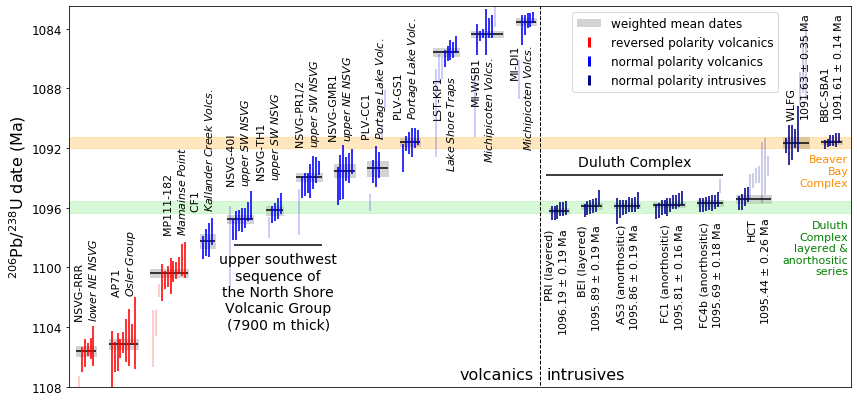

In [26]:
fig, ax, x_positions = plot_dates(MCR_geochron.U_Pb_zircon_dates, MCR_geochron.U_Pb_zircon_2sigmas, 
                                  MCR_geochron.U_Pb_zircon_include, 
                                  MCR_geochron.U_Pb_sample_mean, MCR_geochron.U_Pb_sample_2sigma, 
                                  colors, labels, legend=False, figsize=(14,7), lineweight=2)

max_x_value = 244
ax.set_xlim(0,max_x_value)
ax.set_xticks([])
ax.set_yticks(np.arange(1084,1110,4))
ax.set_yticklabels(np.arange(1084,1110,4),fontsize=12)
ax.yaxis.label.set_size(16)
ax.set_ylim(1108,1082.5)

ax.text(x_positions[0]+1,1105.60-2,'NSVG-RRR \n$\mathit{lower\;NE\;NSVG}$',size='11',horizontalalignment='right',
         verticalalignment='bottom',multialignment='left',rotation=90)
ax.text(x_positions[1],1105.15-3.25,'AP71 \n$\mathit{Osler\;Group}$',size='11',horizontalalignment='right',
        verticalalignment='bottom',multialignment='left',rotation=90)
ax.text(x_positions[2],1100.36-2.5,'MP111-182 \n$\mathit{Mamainse\;Point}$',size='11',horizontalalignment='right',
        verticalalignment='bottom',multialignment='left',rotation=90)
ax.text(x_positions[3],1098.24-2,'CF1 \n$\mathit{Kallander\;Creek\;Volcs.}$',size='11',horizontalalignment='right',
        verticalalignment='bottom',multialignment='left',rotation=90)
ax.text(x_positions[4],1096.75-2.2,'NSVG-40I \n$\mathit{upper\;SW\;NSVG}$',size='11',horizontalalignment='right',
        verticalalignment='bottom',multialignment='left',rotation=90)
ax.text(x_positions[5],1096.18-2,'NSVG-TH1 \n$\mathit{upper\;SW\;NSVG}$',size='11',horizontalalignment='right',
        verticalalignment='bottom',multialignment='left',rotation=90)
ax.text(x_positions[6],1093.94-2,'NSVG-PR1/2 \n$\mathit{upper\;SW\;NSVG}$',size='11',horizontalalignment='right',
        verticalalignment='bottom',multialignment='left',rotation=90)
ax.text(x_positions[7],1093.52-2,'NSVG-GMR1 \n$\mathit{upper\;NE\;NSVG}$',size='11',horizontalalignment='right',
        verticalalignment='bottom',multialignment='left',rotation=90)
ax.text(x_positions[8],1093.37-2,'PLV-CC1 \n$\mathit{Portage\;Lake\;Volc.}$',size='11',horizontalalignment='right',
        verticalalignment='bottom',multialignment='left',rotation=90)
ax.text(x_positions[9],1091.59-1.5,'PLV-GS1 \n$\mathit{Portage\;Lake\;Volc.}$',size='11',horizontalalignment='right',
        verticalalignment='bottom',multialignment='left',rotation=90)
ax.text(x_positions[10],1085.57+1.5,'LST-KP1\n$\mathit{Lake\;Shore\;Traps}$',size='11',horizontalalignment='right',
        verticalalignment='top',multialignment='right',rotation=90)
ax.text(x_positions[11]-2,MI_WSB1_mean+1.5,'MI-WSB1\n$\mathit{Michipicoten\;Volcs.}$',size='11',horizontalalignment='right',
        verticalalignment='top',multialignment='right',rotation=90)
ax.text(x_positions[12],1083.52+1.5,'MI-DI1\n$\mathit{Michipicoten\;Volcs.}$',size='11',horizontalalignment='right',
        verticalalignment='top',multialignment='right',rotation=90)

ax.text(x_positions[13],1096.19+1.2,'PRI (layered)\n1096.19 $\pm$ 0.19 Ma',size='11',horizontalalignment='right',
        verticalalignment='top',multialignment='right',rotation=90)
ax.text(x_positions[14],1095.89+1.2,'BEI (layered)\n1095.89 $\pm$ 0.19 Ma',size='11',horizontalalignment='right',
        verticalalignment='top',multialignment='right',rotation=90)
ax.text(x_positions[15],1095.86+1.2,'AS3 (anorthositic)\n1095.86 $\pm$ 0.19 Ma',size='11',horizontalalignment='right',
        verticalalignment='top',multialignment='right',rotation=90)
ax.text(x_positions[16],1095.81+1.2,'FC1 (anorthositic)\n1095.81 $\pm$ 0.16 Ma',size='11',horizontalalignment='right',
        verticalalignment='top',multialignment='right',rotation=90)
ax.text(x_positions[17],1095.71+1.2,'FC4b (anorthositic)\n1095.69 $\pm$ 0.18 Ma',size='11',horizontalalignment='right',
        verticalalignment='top',multialignment='right',rotation=90)
ax.text(x_positions[18],1095.44+1.2,'HCT\n1095.44 $\pm$ 0.26 Ma',size='11',horizontalalignment='right',
        verticalalignment='top',multialignment='right',rotation=90)
ax.text(x_positions[19]+0.5,1091.63-1.5,'WLFG \n1091.63 $\pm$ 0.35 Ma',size='11',horizontalalignment='right',
        verticalalignment='bottom',multialignment='left',rotation=90)
ax.text(x_positions[20]+0.5,1091.61-1.5,'BBC-SBA1\n1091.61 $\pm$ 0.14 Ma',size='11',horizontalalignment='right',
        verticalalignment='bottom',multialignment='left',rotation=90)

rectangle = matplotlib.patches.Rectangle((0,1095.71 - 0.17),300, (1096.19 + 0.19)-(1095.71 - 0.17), color='lightgreen',alpha=0.35)
ax.add_patch(rectangle)
ax.text(max_x_value-0.75, 1096.19 + 0.19 + 0.45, 'Duluth\nComplex\nlayered &\nanorthositic\nseries', color='green' ,size='11',
        verticalalignment='top',horizontalalignment='right')

rectangle = matplotlib.patches.Rectangle((0,1091.63 - 0.35),300, (1091.63 + 0.35)-(1091.63 - 0.35), color='orange',alpha=0.25)
ax.add_patch(rectangle)
ax.text(max_x_value-0.75, 1091.63 + 0.35 + 0.45, 'Beaver\nBay\nComplex', color='darkorange' ,size='11',
        verticalalignment='top', horizontalalignment='right')

ext_int_split = 147
plt.vlines(ext_int_split,1110,1000,linewidths=1,linestyle='--')
plt.text(ext_int_split-2,1107.5,'volcanics',horizontalalignment='right',fontsize=16)
plt.text(ext_int_split+2,1107.5,'intrusives',horizontalalignment='left',fontsize=16)

plt.hlines(1098.5,x_positions[3]+6,x_positions[6])
plt.text((x_positions[3]+6+x_positions[6])/2,1099,'upper southwest\nsequence of\nthe North Shore\nVolcanic Group\n(7900 m thick)',verticalalignment='top',
         horizontalalignment='center',fontsize=14)

plt.hlines(1093.8,x_positions[12]+3,x_positions[17])
plt.text((x_positions[12]+3+x_positions[17])/2,1093.2,'Duluth Complex',horizontalalignment='center',fontsize=14)

legend_elements = [Patch(facecolor='lightgrey', edgecolor=None,
                         label='weighted mean dates'),
                   Line2D([], [],  marker='|', linestyle='None', color='red', label='reversed polarity volcanics',
                          markerfacecolor='k', markersize=10, markeredgewidth=3),
                   Line2D([], [],  marker='|', linestyle='None', color='blue', label='normal polarity volcanics',
                          markerfacecolor='k', markersize=10, markeredgewidth=3),
                   Line2D([], [],  marker='|', linestyle='None', color='darkblue', label='normal polarity intrusives',
                          markerfacecolor='k', markersize=10, markeredgewidth=3)]

plt.legend(handles=legend_elements, loc='upper right',
           bbox_to_anchor=(.915,1), fancybox=True, fontsize = 12)

plt.savefig('../manuscript/figures/MCR_dates.pdf',bbox_inches='tight')
plt.show(fig)

## Comparison between dates

Here we take two approaches to estimate the duration between dates. One is to linearly propagate the 2sigma uncertainty `diff_uncertainty = np.sqrt(date1_2sigma**2 + date2_2sigma**2)`. The other is to do a Monte Carlo simulation where dates are randomly sampled from normal distribution associated with the two dates and the duration between the samples is determined. If the difference includes zero, we consider the dates to be indistinguishable from one another.

In [27]:
def age_diff(date1,date1_2sigma,date1_label,date2,date2_2sigma,date2_label,nMC=1000000,date_axis_length=1.2):
    
    diff = date1 - date2
    diff_uncertainty = np.sqrt(date1_2sigma**2 + date2_2sigma**2)
    print('difference between ' + str(date1_label) + ' and ' + str(date2_label) + ' = ' + str(np.round(diff,decimals=3)))
    print('linearly propagated 2σ uncertainty of the difference = ' + str(np.round(diff_uncertainty,decimals=3)))

    date1_mc = np.random.normal(date1,date1_2sigma/2,nMC)
    date2_mc = np.random.normal(date2,date2_2sigma/2,nMC)
    diff_mc = date1_mc-date2_mc
    diff_median = np.median(diff_mc)
    diff_percent97_5 = np.percentile(diff_mc,97.5)
    diff_percent2_5 = np.percentile(diff_mc,2.5)
    
    print('\n97.5 percentile of difference in Monte Carlo simulations = ' + str(np.round(diff_percent97_5,decimals=3)))
    print('2.5 percentile of difference in Monte Carlo simulations = ' + str(np.round(diff_percent2_5,decimals=3)))
    
    ax1 = plt.subplot(2,1,1)
    ax1.hist(date1_mc, histtype='step',bins=100,label=date1_label)
    ax1.hist(date2_mc, histtype='step',bins=100,label=date2_label)
    ax1.set_xlabel('age (Ma)')
    ax1.set_xlim((date1+date2)/2 + date_axis_length/2, (date1+date2)/2 - date_axis_length/2)
    ax1.legend()
    
    ax2 = plt.subplot(2,1,2)
    n_diff, x_diff, diff_hist = ax2.hist(diff_mc,bins=100,color='C3',label='duration')
    ax2.vlines(diff_median,0,np.max(n_diff)*1.1,color='black')
    ax2.vlines(diff_percent97_5,0,np.max(n_diff)*1.1,color='black',linestyle='--')
    ax2.vlines(diff_percent2_5,0,np.max(n_diff)*1.1,color='black',linestyle='--')
    ax2.set_xlabel('age difference (Ma)')
    ax2.set_xlim(diff_median - date_axis_length/2, diff_median + date_axis_length/2)
    ax2.set_ylim(0,np.max(n_diff)*1.1)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

difference between FC1 (Ibanez and Tissot, 2019) and FC1 = 0.164
linearly propagated 2σ uncertainty of the difference = 0.271

97.5 percentile of difference in Monte Carlo simulations = 0.429
2.5 percentile of difference in Monte Carlo simulations = -0.102


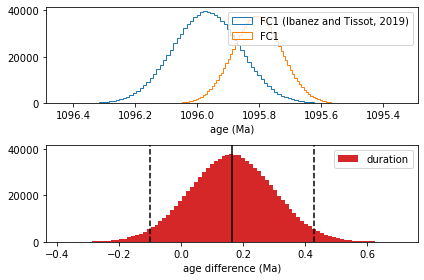

In [28]:
FC1_mean_Ibanez = 1095.97
FC1_2sigma_Ibanez = 0.22

age_diff(FC1_mean_Ibanez,FC1_2sigma_Ibanez,'FC1 (Ibanez and Tissot, 2019)',FC1_mean,FC1_2sigma,'FC1')

difference between FC1 and FC4b = 0.117
linearly propagated 2σ uncertainty of the difference = 0.239

97.5 percentile of difference in Monte Carlo simulations = 0.351
2.5 percentile of difference in Monte Carlo simulations = -0.117


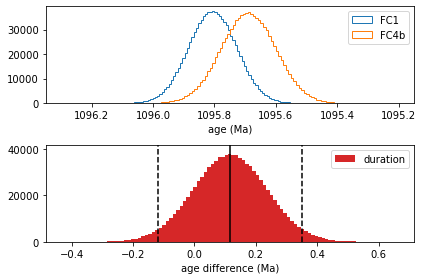

In [29]:
age_diff(FC1_mean,FC1_2sigma,'FC1',FC4b_mean,FC4b_2sigma,'FC4b')

difference between AS3 and FC1 = 0.056
linearly propagated 2σ uncertainty of the difference = 0.245

97.5 percentile of difference in Monte Carlo simulations = 0.296
2.5 percentile of difference in Monte Carlo simulations = -0.185


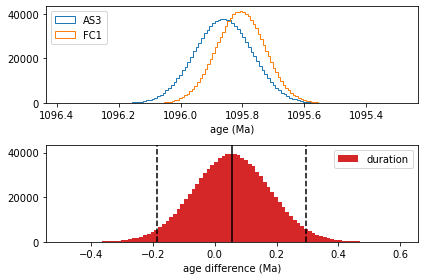

In [30]:
age_diff(AS3_mean,AS3_2sigma,'AS3',FC1_mean,FC1_2sigma,'FC1')

difference between AS3 and FC4b = 0.172
linearly propagated 2σ uncertainty of the difference = 0.259

97.5 percentile of difference in Monte Carlo simulations = 0.426
2.5 percentile of difference in Monte Carlo simulations = -0.081


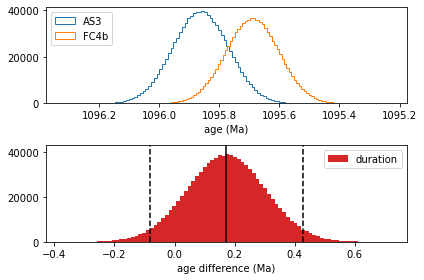

In [31]:
age_diff(AS3_mean,AS3_2sigma,'AS3',FC4b_mean,FC4b_2sigma,'FC4b')

difference between BEI and AS3 = 0.022
linearly propagated 2σ uncertainty of the difference = 0.267

97.5 percentile of difference in Monte Carlo simulations = 0.285
2.5 percentile of difference in Monte Carlo simulations = -0.241


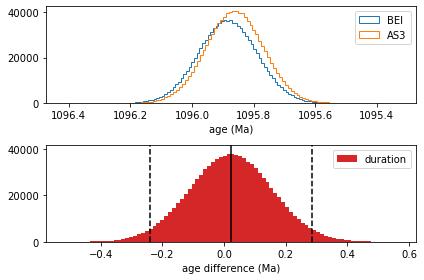

In [32]:
age_diff(BEI_mean,BEI_2sigma,'BEI',AS3_mean,AS3_2sigma,'AS3')

difference between BEI and FC1 = 0.078
linearly propagated 2σ uncertainty of the difference = 0.248

97.5 percentile of difference in Monte Carlo simulations = 0.321
2.5 percentile of difference in Monte Carlo simulations = -0.165


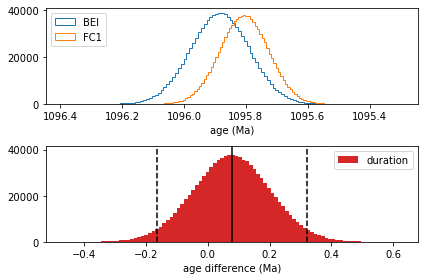

In [33]:
age_diff(BEI_mean,BEI_2sigma,'BEI',FC1_mean,FC1_2sigma,'FC1')

difference between BEI and FC4b = 0.195
linearly propagated 2σ uncertainty of the difference = 0.262

97.5 percentile of difference in Monte Carlo simulations = 0.45
2.5 percentile of difference in Monte Carlo simulations = -0.061


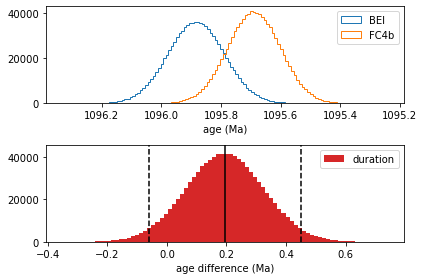

In [34]:
age_diff(BEI_mean,BEI_2sigma,'BEI',FC4b_mean,FC4b_2sigma,'FC4b')

difference between PRI and BEI = 0.31
linearly propagated 2σ uncertainty of the difference = 0.268

97.5 percentile of difference in Monte Carlo simulations = 0.572
2.5 percentile of difference in Monte Carlo simulations = 0.047


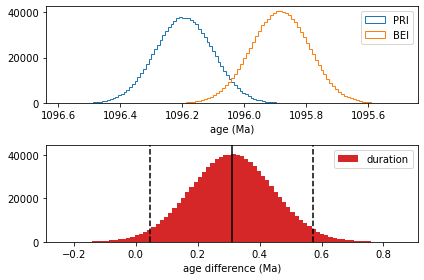

In [35]:
age_diff(PRI_mean,PRI_2sigma,'PRI',BEI_mean,BEI_2sigma,'BEI')

difference between PRI and AS3 = 0.333
linearly propagated 2σ uncertainty of the difference = 0.265

97.5 percentile of difference in Monte Carlo simulations = 0.593
2.5 percentile of difference in Monte Carlo simulations = 0.073


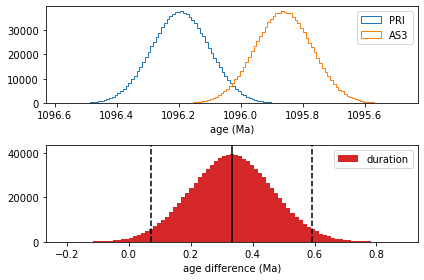

In [36]:
age_diff(PRI_mean,PRI_2sigma,'PRI',AS3_mean,AS3_2sigma,'AS3')

difference between PRI and FC1 = 0.388
linearly propagated 2σ uncertainty of the difference = 0.246

97.5 percentile of difference in Monte Carlo simulations = 0.629
2.5 percentile of difference in Monte Carlo simulations = 0.148


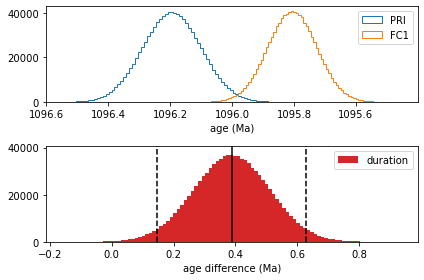

In [37]:
age_diff(PRI_mean,PRI_2sigma,'PRI',FC1_mean,FC1_2sigma,'FC1')

difference between PRI and FC4b = 0.505
linearly propagated 2σ uncertainty of the difference = 0.26

97.5 percentile of difference in Monte Carlo simulations = 0.759
2.5 percentile of difference in Monte Carlo simulations = 0.25


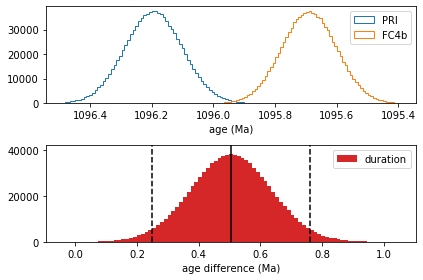

In [38]:
age_diff(PRI_mean,PRI_2sigma,'PRI',FC4b_mean,FC4b_2sigma,'FC4b')

difference between FC4b and HCT = 0.369
linearly propagated 2σ uncertainty of the difference = 0.303

97.5 percentile of difference in Monte Carlo simulations = 0.666
2.5 percentile of difference in Monte Carlo simulations = 0.071


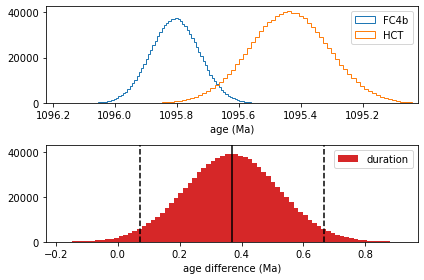

In [39]:
age_diff(FC1_mean,FC1_2sigma,'FC4b',HCT_mean,HCT_2sigma,'HCT')

difference between FC4b and HCT = 0.252
linearly propagated 2σ uncertainty of the difference = 0.314

97.5 percentile of difference in Monte Carlo simulations = 0.56
2.5 percentile of difference in Monte Carlo simulations = -0.056


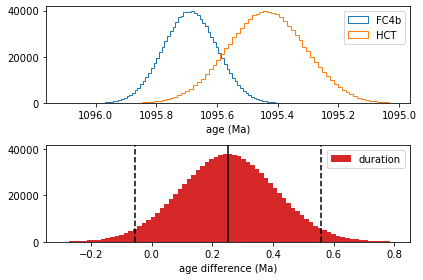

In [40]:
age_diff(FC4b_mean,FC4b_2sigma,'FC4b',HCT_mean,HCT_2sigma,'HCT')

difference between D1_PM93 and PG2_PM93 = 0.7
linearly propagated 2σ uncertainty of the difference = 0.583

97.5 percentile of difference in Monte Carlo simulations = 1.272
2.5 percentile of difference in Monte Carlo simulations = 0.129


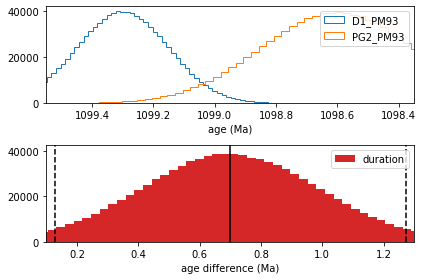

In [41]:
D1_PM93_mean = 1099.3
D1_PM93_2sigma = 0.3

PG2_PM93_mean = 1098.6
PG2_PM93_2sigma = 0.5

age_diff(D1_PM93_mean,D1_PM93_2sigma,'D1_PM93',PG2_PM93_mean,PG2_PM93_2sigma,'PG2_PM93')

difference between D1_PM93 and PG2_PM93 = 0.5
linearly propagated 2σ uncertainty of the difference = 0.707

97.5 percentile of difference in Monte Carlo simulations = 1.193
2.5 percentile of difference in Monte Carlo simulations = -0.192


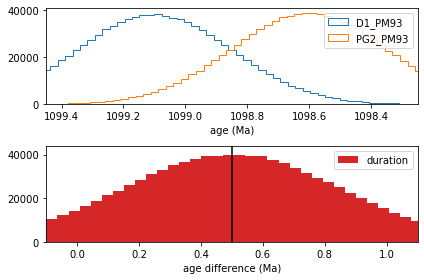

In [42]:
D1_PM93_mean = 1099.1
D1_PM93_2sigma = 0.5

PG2_PM93_mean = 1098.6
PG2_PM93_2sigma = 0.5

age_diff(D1_PM93_mean,D1_PM93_2sigma,'D1_PM93',PG2_PM93_mean,PG2_PM93_2sigma,'PG2_PM93')

# Duluth Complex paleomagnetic data compilation

Beck (1970) published results from intrusive rocks of the Midcontinent Rift in northern Minnesota including the Duluth Complex. The details of the site mean directions, site locations and lithologies are available within Beck's PhD thesis that was published in 1969. These data can be assigned to intrusive units associated with more recent mapping efforts (Miller et al., 2001) and include abundant data from the anorthositic and layered series of the Duluth Complex.

*Beck Jr, M.E., 1970. Paleomagnetism of Keweenawan intrusive rocks, Minnesota. Journal of Geophysical Research, 75(26), pp. 4985-4996.*

The Beck (1970) study utilized blanket alternating field demagnetization steps of 7.5, 15 and 30 mT and chose to use the directions associated with the step where there was the highest concentration of directions. Given that Midcontinent Rift magnetizations are typically single-component, it is likely that this approach yielded acceptable site mean directions.

## Import and plot the Beck (1970) sites from the Duluth Complex

In [43]:
Beck1969a_sites = pd.read_csv('../data/pmag_compiled/Beck1969a_sites.txt',sep='\t',header=1)
Beck_Anorthositic_series = Beck1969a_sites[Beck1969a_sites['location'] == 'Anorthositic series']
Beck_Layered_series = Beck1969a_sites[Beck1969a_sites['location'] == 'Layered series']

In [44]:
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import img_tiles
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
lakes_10m = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['water'])
lakes_50m = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['water'])
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

Laurentia_outline = ShapelyFeature(Reader('../data/Laurentia_shape/Laurentia.shp').geometries(),
                                ccrs.PlateCarree(), facecolor = 'none', edgecolor='black')

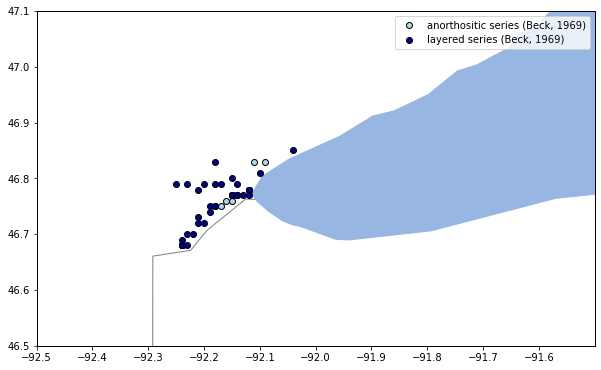

In [45]:
central_lat = 46.75
central_lon = -92
extent = [central_lon-0.5, central_lon+0.5, central_lat-0.25, central_lat+0.25]

plt.figure(1,(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)
plt.scatter(Beck_Anorthositic_series.lon, Beck_Anorthositic_series.lat,transform=ccrs.PlateCarree(),zorder=100,
            color = 'lightblue', edgecolors='black',label='anorthositic series (Beck, 1969)')
plt.scatter(Beck_Layered_series.lon, Beck_Layered_series.lat,transform=ccrs.PlateCarree(),zorder=100,
            color = 'darkblue', edgecolors='black',label='layered series (Beck, 1969)')

ax.coastlines(resolution='10m')
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(lakes_10m)

ax.set_xticks(np.arange(-92.5,-91.6,0.1).tolist(), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(46.5,47.1,0.1).tolist(), crs=ccrs.PlateCarree())
plt.legend()
plt.show()

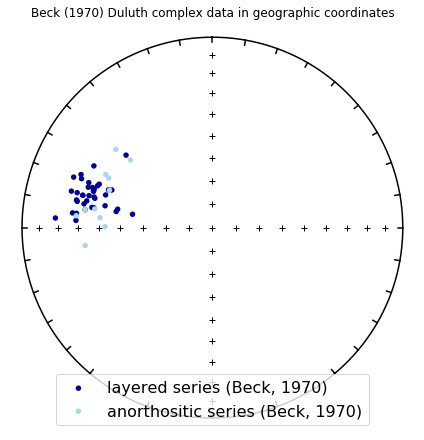

In [46]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(Beck_Layered_series['dir_dec'].tolist(),
              Beck_Layered_series['dir_inc'].tolist(),color='darkblue',
              label='layered series (Beck, 1970)',markersize=30)
ipmag.plot_di(Beck_Anorthositic_series['dir_dec'].tolist(),
              Beck_Anorthositic_series['dir_inc'].tolist(),color='lightblue',
              label='anorthositic series (Beck, 1970)',markersize=30)
plt.legend(loc=8,fontsize=16)
plt.title('Beck (1970) Duluth complex data in geographic coordinates')
plt.show()

## Conduct common mean tests between the layered series and anorthositic series data

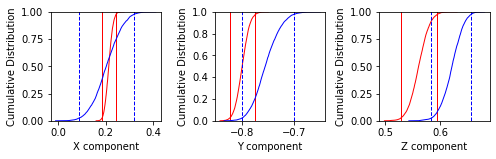

Results of Watson V test: 

Watson's V:           2.1
Critical value of V:  6.8
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 4.4
Critical angle for M&M1990:   7.9
The McFadden and McElhinny (1990) classification for
this test is: 'B'


(1, 4.389215518800642, 7.915000788373825)

In [47]:
Beck_Layered_block = ipmag.make_di_block(Beck_Layered_series['dir_dec'].tolist(),
                                         Beck_Layered_series['dir_inc'].tolist())
Beck_Anortho_block = ipmag.make_di_block(Beck_Anorthositic_series['dir_dec'].tolist(),
                                         Beck_Anorthositic_series['dir_inc'].tolist())
ipmag.common_mean_bootstrap(Beck_Layered_block,Beck_Anortho_block)
ipmag.common_mean_watson(Beck_Layered_block,Beck_Anortho_block)

## M181 Duluth Heights orientation data

In [48]:
# import structural measurements from published map data
Duluth_Heights_structural_data = pd.read_csv('../data/intrusive_orientations/Duluth_Heights_orientations.csv',sep=',')
Duluth_Heights = Duluth_Heights_structural_data[(Duluth_Heights_structural_data.STRUCTURE == 'IL') | (Duluth_Heights_structural_data.STRUCTURE == 'IM') 
                                              | (Duluth_Heights_structural_data.STRUCTURE == 'IU') | (Duluth_Heights_structural_data.STRUCTURE == 'IT')]

In [49]:
Duluth_Heights = Duluth_Heights[Duluth_Heights.Y < 5183000]
Duluth_Heights = Duluth_Heights[Duluth_Heights['DIP_PLUNGE']<35]

In [50]:
Duluth_Heights['strike'] = Duluth_Heights['DIPD_TREND'] - 90
Duluth_Heights['pole_trend'] = Duluth_Heights['DIPD_TREND'] - 180
Duluth_Heights['pole_plunge'] = 90 - Duluth_Heights['DIP_PLUNGE']
mean_plane_pole = ipmag.fisher_mean(Duluth_Heights['pole_trend'].tolist(),Duluth_Heights['pole_plunge'].tolist())
mean_strike = mean_plane_pole['dec'] + 90
mean_dip = 90 - mean_plane_pole['inc']
print(mean_strike, mean_dip)

367.9513341883158 16.344796403566036


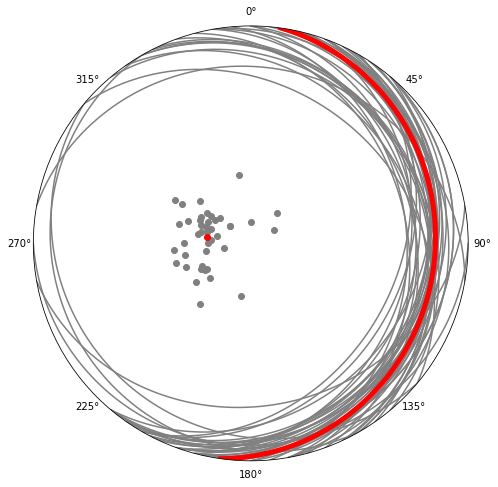

In [51]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='stereonet')
ax.plane(Duluth_Heights['strike'],Duluth_Heights['DIP_PLUNGE'],color='grey')
ax.plane(mean_strike,mean_dip,color='red',linewidth=5)
ax.pole(Duluth_Heights['strike'],Duluth_Heights['DIP_PLUNGE'],color='grey')
ax.pole(mean_strike,mean_dip,color='red')

plt.show()

## Plotting M183 West Duluth map orientations

Here we are plotting the igneous layering, igneous modal or texture layering

In [52]:
# import structural measurements from published map data
West_Duluth_structural_data = pd.read_csv('../data/intrusive_orientations/West_Duluth_orientations.csv',sep=',')
West_Duluth = West_Duluth_structural_data[(West_Duluth_structural_data.STRUCTURE == 'IL') | (West_Duluth_structural_data.STRUCTURE == 'IM') 
                                              | (West_Duluth_structural_data.STRUCTURE == 'IU') | (West_Duluth_structural_data.STRUCTURE == 'IT')]
West_Duluth

,Y,X,ValueId,PolyId,AREA,PERIMETER,WDUL_STRPT,WDUL_STR_1,TYPE,GCM_CODE,GEOC_SRC,GEOC_DATE,FIELD_STA,MEAS_ID,MEAS_DATE,GEOL_1,GEOL_2,REFRNCE,STRUCTURE,STRUC_TYPE,DIPD_TREND,DIP_PLUNGE,MRR_RELIAB,N_MEAS,SYM_CODE,DISPLAY,AVANGLE
9,5.169831e+06,558799.132850,10,0,0.0,0.0,10,10,ST,A,MGS,20080615,NaN,MD739.5,20031007,JDM,NaN,NB:MD4/FM:WD5585E/51705N,IM,P,80,45,NaN,1,73,24000,280
10,5.169874e+06,558554.535103,11,0,0.0,0.0,11,11,ST,A,MGS,20080615,NaN,MD587.00.2,19971015,JDM,NaN,NB:MD4/FM:223B.SW2,IM,P,59,24,NaN,1,73,24000,301
11,5.169972e+06,558275.324686,12,0,0.0,0.0,12,12,ST,A,MGS,20080615,NaN,MD591.00.2,19971015,JDM,NaN,NB:MD4/FM:223B.SW2,IM,P,70,34,NaN,0,73,24000,290
12,5.170077e+06,558949.574927,13,0,0.0,0.0,13,13,ST,A,MGS,20080615,NaN,MD736.3,20031007,JDM,NaN,NB:MD4/FM:WD5585E/51705N,IM,P,75,49,NaN,1,73,24000,285
13,5.170094e+06,558419.712396,14,0,0.0,0.0,14,14,ST,A,MGS,20080615,NaN,MD555.00.1,19941021,JDM,NaN,NB:DM3/FM:223B.SW2,IT,P,63,37,NaN,1,73,24000,297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,5.177305e+06,562249.038259,183,0,0.0,0.0,183,183,ST,A,MGS,20080615,NaN,MD205.00.2,19920819,JDM,NaN,NB:DM2/FM:223B.NC1,IT,P,65,35,NaN,1,73,24000,295
183,5.177331e+06,561145.444574,184,0,0.0,0.0,184,184,ST,A,MGS,20080615,NaN,MD189.00.1,19920814,JDM,NaN,NB:DM2/FM:223B.NC1,IL,P,90,10,NaN,1,103,24000,270
184,5.177455e+06,561363.004356,185,0,0.0,0.0,185,185,ST,A,MGS,20080615,NaN,MD648.1,19971021,JDM,NaN,NB:MD4/FM:223B.NC,IM,P,128,15,NaN,1,73,12000,232
185,5.177605e+06,562167.927481,186,0,0.0,0.0,186,186,ST,A,MGS,20080615,NaN,MD202.00.1,19920819,JDM,NaN,NB:DM2/FM:223B.NC1,IL,P,129,19,NaN,1,103,24000,231


In [53]:
West_Duluth = West_Duluth[West_Duluth['DIP_PLUNGE']<35]

In [54]:
West_Duluth['strike'] = West_Duluth['DIPD_TREND'] - 90
West_Duluth['pole_trend'] = West_Duluth['DIPD_TREND'] - 180
West_Duluth['pole_plunge'] = 90 - West_Duluth['DIP_PLUNGE']
mean_plane_pole = ipmag.fisher_mean(West_Duluth['pole_trend'].tolist(),West_Duluth['pole_plunge'].tolist())
mean_strike = mean_plane_pole['dec'] + 90
mean_dip = 90 - mean_plane_pole['inc']
print(mean_strike, mean_dip)

351.92633364731483 18.271165297678067


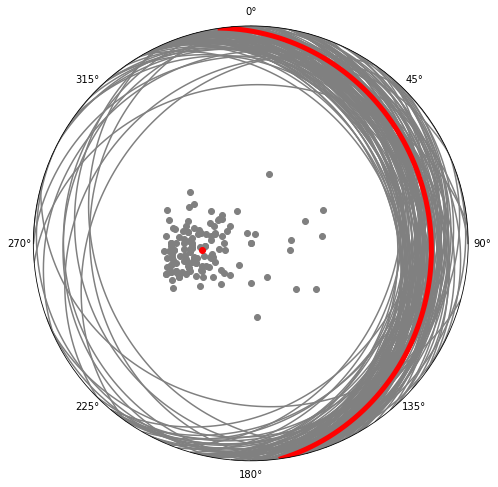

In [55]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='stereonet')
ax.plane(West_Duluth['strike'],West_Duluth['DIP_PLUNGE'],color='grey')
ax.plane(mean_strike,mean_dip,color='red',linewidth=5)
ax.pole(West_Duluth['strike'],West_Duluth['DIP_PLUNGE'],color='grey')
ax.pole(mean_strike,mean_dip,color='red')

plt.show()

## Plotting M182 Duluth map orientations

Here we are plotting orientations from North Shore Volcanic Group lavas overlying the Duluth Complex to compare the mean orientation to that of the igneous foliations compiled above. They show good consistency in the overall orientation. 

In [56]:
# import structural measurements from published map data
Duluth_structural_data = pd.read_csv('../data/intrusive_orientations/Duluth_orientations.csv',sep=',')
Duluth = Duluth_structural_data[(Duluth_structural_data.STRUCTURE == 'VF') | (Duluth_structural_data.STRUCTURE == 'SB') 
                                | (Duluth_structural_data.STRUCTURE == 'VC') | (Duluth_structural_data.STRUCTURE == 'VB') 
                                | (Duluth_structural_data.STRUCTURE == 'JJ')]

There are a few steep outliers (both in dip direction and dip that can be filtered out.

In [57]:
Duluth = Duluth[Duluth['DIP_PLUNGE']<35]

In [58]:
Duluth['strike'] = Duluth['DIPD_TREND'] - 90
Duluth['pole_trend'] = Duluth['DIPD_TREND'] - 180
Duluth['pole_plunge'] = 90 - Duluth['DIP_PLUNGE']
mean_plane_pole = ipmag.fisher_mean(Duluth['pole_trend'].tolist(),Duluth['pole_plunge'].tolist())
mean_strike = mean_plane_pole['dec'] + 90
mean_dip = 90 - mean_plane_pole['inc']
print(mean_strike, mean_dip)

369.7403758826295 18.386093074433518


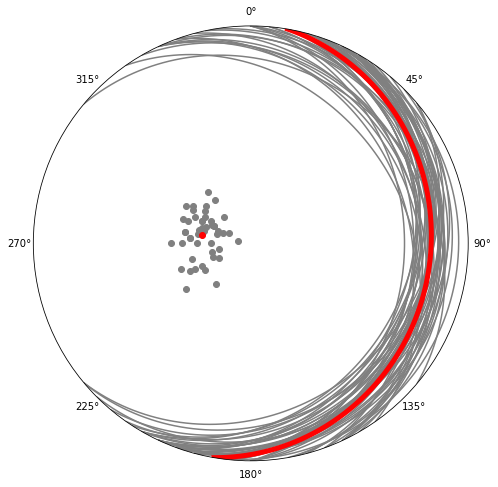

In [59]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='stereonet')
ax.plane(Duluth['strike'],Duluth['DIP_PLUNGE'],color='grey')
ax.plane(mean_strike,mean_dip,color='red',linewidth=5)
ax.pole(Duluth['strike'],Duluth['DIP_PLUNGE'],color='grey')
ax.pole(mean_strike,mean_dip,color='red')

plt.show()

## Tilt correct the data

We can combine the structural measurements from West Duluth and Duluth Heights to calculate an overall mean direction that can be used to tilt correct the paleomagnetic site data.

In [60]:
Duluth_mean_plane_pole = ipmag.fisher_mean(West_Duluth['pole_trend'].tolist()+Duluth_Heights['pole_trend'].tolist(),
                                    West_Duluth['pole_plunge'].tolist()+Duluth_Heights['pole_plunge'].tolist())
Duluth_mean_strike = Duluth_mean_plane_pole['dec'] + 90
Duluth_mean_dip = 90 - Duluth_mean_plane_pole['inc']
print(Duluth_mean_strike, Duluth_mean_dip)

355.488656622132 17.69040648835825


In [61]:
tilt_correction_dd = Duluth_mean_strike + 90
tilt_correction_dip = Duluth_mean_dip

Beck_Anorthositic_series['dec_tc'] = [pmag.dotilt(Beck_Anorthositic_series['dir_dec'].tolist()[i], Beck_Anorthositic_series['dir_inc'].tolist()[i], tilt_correction_dd, tilt_correction_dip)[0] 
                                      for i in range(len(Beck_Anorthositic_series['dir_dec']))]
Beck_Anorthositic_series['inc_tc'] = [pmag.dotilt(Beck_Anorthositic_series['dir_dec'].tolist()[i], Beck_Anorthositic_series['dir_inc'].tolist()[i], tilt_correction_dd, tilt_correction_dip)[1] 
                                      for i in range(len(Beck_Anorthositic_series['dir_dec']))]
Beck_Layered_series['dec_tc'] = [pmag.dotilt(Beck_Layered_series['dir_dec'].tolist()[i], Beck_Layered_series['dir_inc'].tolist()[i], tilt_correction_dd, tilt_correction_dip)[0] 
                                      for i in range(len(Beck_Layered_series['dir_dec']))]
Beck_Layered_series['inc_tc'] = [pmag.dotilt(Beck_Layered_series['dir_dec'].tolist()[i], Beck_Layered_series['dir_inc'].tolist()[i], tilt_correction_dd, tilt_correction_dip)[1] 
                                      for i in range(len(Beck_Layered_series['dir_dec']))]

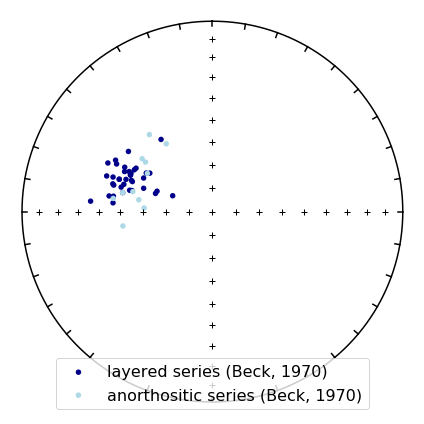

In [62]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(Beck_Layered_series['dec_tc'].tolist(),
              Beck_Layered_series['inc_tc'].tolist(),color='darkblue',
              label='layered series (Beck, 1970)',markersize=30)
ipmag.plot_di(Beck_Anorthositic_series['dec_tc'].tolist(),
              Beck_Anorthositic_series['inc_tc'].tolist(),color='lightblue',
              label='anorthositic series (Beck, 1970)',markersize=30)
plt.legend(loc=8,fontsize=16)
# plt.savefig('./code_output/Beck_site_directions.pdf')
plt.show()

In [63]:
Beck_Anorthositic_series_tilt_corrected = ipmag.vgp_calc(Beck_Anorthositic_series, tilt_correction='yes',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc',
    dec_tc='dec_tc',
    inc_tc='inc_tc',
)

Beck_Layered_series_tilt_corrected = ipmag.vgp_calc(Beck_Layered_series, tilt_correction='yes',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc',
    dec_tc='dec_tc',
    inc_tc='inc_tc',
)

In [64]:
Beck_Layered_series_tilt_corrected['dir_alpha95'] = 140/np.sqrt(Beck_Layered_series_tilt_corrected['dir_k']*Beck_Layered_series_tilt_corrected['dir_n_specimens'])
Beck_Layered_filtered = Beck_Layered_series_tilt_corrected[Beck_Layered_series_tilt_corrected['dir_alpha95']<15]

Beck_Anorthositic_series_tilt_corrected['dir_alpha95'] = 140/np.sqrt(Beck_Anorthositic_series_tilt_corrected['dir_k']*Beck_Anorthositic_series_tilt_corrected['dir_n_specimens'])
Beck_Anorthositic_filtered = Beck_Anorthositic_series_tilt_corrected[Beck_Anorthositic_series_tilt_corrected['dir_alpha95']<15]

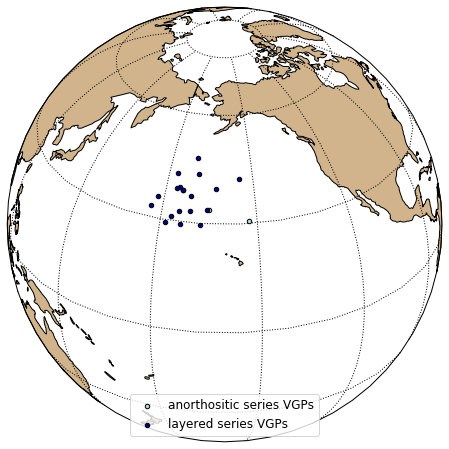

In [65]:
map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=30)
ipmag.plot_vgp(map_axis,vgp_lon=Beck_Anorthositic_filtered.vgp_lon,
               vgp_lat=Beck_Anorthositic_filtered.vgp_lat,color='lightblue',
               label='anorthositic series VGPs')
ipmag.plot_vgp(map_axis,vgp_lon=Beck_Layered_filtered.vgp_lon,
               vgp_lat=Beck_Layered_filtered.vgp_lat,color='darkblue',
               label='layered series VGPs')

plt.legend(loc=8, scatterpoints=1, fontsize=12)
plt.show()

## New data from the anorthositic series

Here we plot the paleomagnetic data from sites FC1 and FC4 of the anorthositic series from where the geochronology samples were collected.

There are not structural measurements from within the anorthositic series in this locality that can be used for tilt-correction. However, there are measurements higher in the intrusive pile such as in the Houghtaling Creek Troctolite. Given the large-scale regional tilt, these measurements can be used for the FC sites.

In [66]:
# import structural measurements from published map data
HCT_orientations = pd.read_csv('../data/intrusive_orientations/HCT_WLFG_geochron_orientations.csv',sep=',')
HCT_orientations = HCT_orientations[(HCT_orientations.STRUCTURE == 'IL') | (HCT_orientations.STRUCTURE == 'IM') | (HCT_orientations.STRUCTURE == 'IU')]
HCT_orientations = HCT_orientations[HCT_orientations['DIP_PLUNGE']<25]
HCT_orientations = HCT_orientations[HCT_orientations['DIPD_TREND']<220]

In [67]:
HCT_orientations['strike'] = HCT_orientations['DIPD_TREND'] - 90
HCT_orientations['pole_trend'] = HCT_orientations['DIPD_TREND'] - 180
HCT_orientations['pole_plunge'] = 90 - HCT_orientations['DIP_PLUNGE']
HCT_mean_plane_pole = ipmag.fisher_mean(HCT_orientations['pole_trend'].tolist(),HCT_orientations['pole_plunge'].tolist())
HCT_mean_strike = (HCT_mean_plane_pole['dec'] + 90)%360
HCT_mean_dip = 90 - HCT_mean_plane_pole['inc']
print(HCT_mean_strike, HCT_mean_dip)

48.970981220873455 12.601368067405502


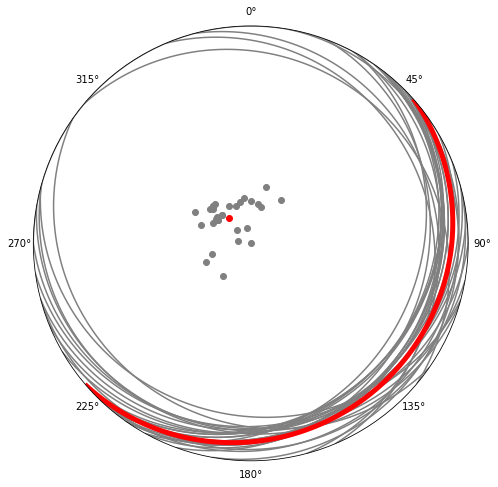

In [68]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='stereonet')
ax.plane(HCT_orientations['strike'],HCT_orientations['DIP_PLUNGE'],color='grey')
ax.plane(HCT_mean_strike,HCT_mean_dip,color='red',linewidth=5)
ax.pole(HCT_orientations['strike'],HCT_orientations['DIP_PLUNGE'],color='grey')
ax.pole(HCT_mean_strike,HCT_mean_dip,color='red')

plt.show()

## New paleomagnetic data

In [69]:
# load MagIC table
North_Shore = pd.read_csv('../data/pmag_new/sites.txt', sep='\t',header=1)

# filter by tilt correction and component 
North_Shore = North_Shore[North_Shore['dir_tilt_correction'] == 0]
North_Shore = North_Shore[(North_Shore['dir_comp_name'] == 'mc') | (North_Shore['dir_comp_name'] == 'mt')]

#define the tilt correction
FC_dip_direction = HCT_mean_strike + 90
FC_dip = HCT_mean_dip

# do the tilt correction
North_Shore['dec_tc'] = [pmag.dotilt(North_Shore['dir_dec'].tolist()[i], North_Shore['dir_inc'].tolist()[i], 
                                                  FC_dip_direction, FC_dip)[0] for i in range(len(North_Shore['dir_dec']))]

North_Shore['inc_tc'] = [pmag.dotilt(North_Shore['dir_dec'].tolist()[i], North_Shore['dir_inc'].tolist()[i], 
                                                  FC_dip_direction, FC_dip)[1] for i in range(len(North_Shore['dir_dec']))]

North_Shore = ipmag.vgp_calc(North_Shore, tilt_correction='yes',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc',
    dec_tc='dec_tc',
    inc_tc='inc_tc',
)

# split out by site/method
FC1_AF = North_Shore[(North_Shore['site'].str.contains('FC1')) & (North_Shore['dir_comp_name'] == 'mc')]
FC4_AF = North_Shore[(North_Shore['site'].str.contains('FC4')) & (North_Shore['dir_comp_name'] == 'mc')]
FC1_thermal = North_Shore[(North_Shore['site'].str.contains('FC1')) & (North_Shore['dir_comp_name'] == 'mt')]
HCT_AF = North_Shore[(North_Shore['site'].str.contains('HCT')) & (North_Shore['dir_comp_name'] == 'mc')]
HCT_thermal = North_Shore[(North_Shore['site'].str.contains('HCT')) & (North_Shore['dir_comp_name'] == 'mt')]


HCT_thermal

,site,location,samples,specimens,dir_alpha95,dir_comp_name,dir_dec,dir_inc,dir_k,dir_n_samples,dir_n_specimens,dir_n_specimens_lines,dir_n_specimens_planes,dir_polarity,dir_r,dir_tilt_correction,lat,lon,analysts,criteria,software_packages,citations,method_codes,result_quality,dec_tc,inc_tc,paleolatitude,vgp_lat,vgp_lon,vgp_lat_rev,vgp_lon_rev
10,HCT1,North,HCT1-1:HCT1-2:HCT1-3:HCT1-5:HCT1-6:HCT1-8,HCT1-1b:HCT1-2b:HCT1-3b:HCT1-5b:HCT1-6b:HCT1-8b,5.6,mt,285.7,45.3,144,6,6,6,0,NaN,5.9652,0,47.6008,-91.1495,Yiming Zhang,ACCEPT,pmagpy-4.2.25: demag_gui.v.3.0,This study,LP-DIR-T:DE-BFL:DA-DIR-GEO:LP-DC4:DE-FM,g,276.317559,55.283566,35.816076,29.492268,201.037076,-29.492268,21.037076


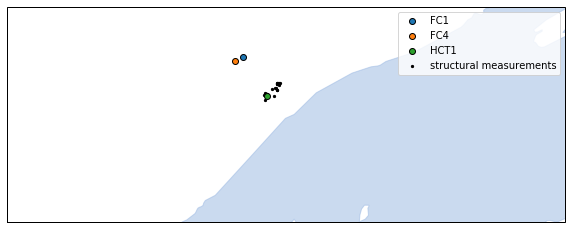

In [70]:
from pyproj import Proj

myProj = Proj("+proj=utm +zone=15N, +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
lon, lat = myProj(HCT_orientations['UTME'].values, HCT_orientations['UTMN'].values, inverse=True)

central_lat = 48
central_lon = -90
extent = [central_lon-3, central_lon+1, central_lat-1, central_lat+0]

plt.figure(1,(10,10))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-90, central_latitude=50))
ax.set_extent(extent)

plt.scatter(FC1_AF.lon.tolist()[0], FC1_AF.lat.tolist()[0],transform=ccrs.PlateCarree(),zorder=100,color = 'C0', 
            edgecolors='black', label = FC1_AF.site.tolist()[0])
plt.scatter(FC4_AF.lon.tolist()[0], FC4_AF.lat.tolist()[0],transform=ccrs.PlateCarree(),zorder=100,color = 'C1', 
            edgecolors='black', label = FC4_AF.site.tolist()[0])
plt.scatter(HCT_thermal.lon.tolist()[0], HCT_thermal.lat.tolist()[0],transform=ccrs.PlateCarree(),color = 'C2', 
            edgecolors='black', label = HCT_thermal.site.tolist()[0],zorder=1000)
    
plt.scatter(lon.tolist(), lat.tolist(),zorder=100,transform=ccrs.PlateCarree(), color='black', label='structural measurements',s=5)

ax.coastlines(resolution='10m')
ax.add_feature(lakes_10m, alpha=0.5)
plt.legend()
plt.show()

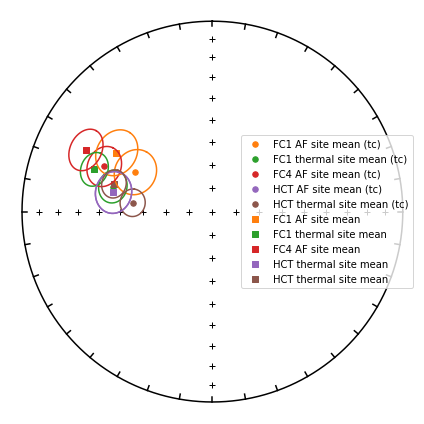

In [71]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di_mean(FC1_AF['dec_tc'].tolist()[0],
              FC1_AF['inc_tc'].tolist()[0], FC1_AF['dir_alpha95'].tolist()[0], color='C1',
              label='FC1 AF site mean (tc)',markersize=30)
ipmag.plot_di_mean(FC1_thermal['dec_tc'].tolist()[0],
              FC1_thermal['inc_tc'].tolist()[0], FC1_thermal['dir_alpha95'].tolist()[0], color='C2',
              label='FC1 thermal site mean (tc)',markersize=30)
ipmag.plot_di_mean(FC4_AF['dec_tc'].tolist()[0],
              FC4_AF['inc_tc'].tolist()[0], FC4_AF['dir_alpha95'].tolist()[0], color='C3',
              label='FC4 AF site mean (tc)',markersize=30)
ipmag.plot_di_mean(HCT_AF['dec_tc'].tolist()[0],
              HCT_AF['inc_tc'].tolist()[0], HCT_AF['dir_alpha95'].tolist()[0], color='C4',
              label='HCT AF site mean (tc)',markersize=30)
ipmag.plot_di_mean(HCT_thermal['dec_tc'].tolist()[0],
              HCT_thermal['inc_tc'].tolist()[0], HCT_thermal['dir_alpha95'].tolist()[0], color='C5',
              label='HCT thermal site mean (tc)',markersize=30)

ipmag.plot_di_mean(FC1_AF['dir_dec'].tolist()[0],
              FC1_AF['dir_inc'].tolist()[0], FC1_AF['dir_alpha95'].tolist()[0], color='C1',
              label='FC1 AF site mean',markersize=30, marker='s')
ipmag.plot_di_mean(FC1_thermal['dir_dec'].tolist()[0],
              FC1_thermal['dir_inc'].tolist()[0], FC1_thermal['dir_alpha95'].tolist()[0], color='C2',
              label='FC1 thermal site mean',markersize=30, marker='s')
ipmag.plot_di_mean(FC4_AF['dir_dec'].tolist()[0],
              FC4_AF['dir_inc'].tolist()[0], FC4_AF['dir_alpha95'].tolist()[0], color='C3',
              label='FC4 AF site mean',markersize=30, marker='s')
ipmag.plot_di_mean(HCT_AF['dec_tc'].tolist()[0],
              HCT_AF['inc_tc'].tolist()[0], HCT_AF['dir_alpha95'].tolist()[0], color='C4',
              label='HCT thermal site mean',markersize=30, marker='s')
ipmag.plot_di_mean(HCT_thermal['dir_dec'].tolist()[0],
              HCT_thermal['dir_inc'].tolist()[0], HCT_thermal['dir_alpha95'].tolist()[0], color='C5',
              label='HCT thermal site mean',markersize=30, marker='s')
plt.legend()

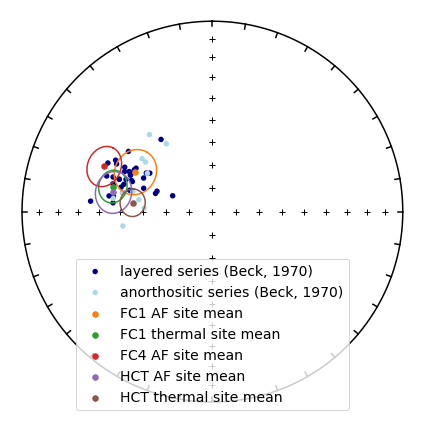

In [72]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(Beck_Layered_series['dec_tc'].tolist(),
              Beck_Layered_series['inc_tc'].tolist(),color='darkblue',
              label='layered series (Beck, 1970)',markersize=30)
ipmag.plot_di(Beck_Anorthositic_series['dec_tc'].tolist(),
              Beck_Anorthositic_series['inc_tc'].tolist(),color='lightblue',
              label='anorthositic series (Beck, 1970)',markersize=30)

ipmag.plot_di_mean(FC1_AF['dec_tc'].tolist()[0],
              FC1_AF['inc_tc'].tolist()[0], FC1_AF['dir_alpha95'].tolist()[0], color='C1',
              label='FC1 AF site mean',markersize=30)
ipmag.plot_di_mean(FC1_thermal['dec_tc'].tolist()[0],
              FC1_thermal['inc_tc'].tolist()[0], FC1_thermal['dir_alpha95'].tolist()[0], color='C2',
              label='FC1 thermal site mean',markersize=30)
ipmag.plot_di_mean(FC4_AF['dec_tc'].tolist()[0],
              FC4_AF['inc_tc'].tolist()[0], FC4_AF['dir_alpha95'].tolist()[0], color='C3',
              label='FC4 AF site mean',markersize=30)
ipmag.plot_di_mean(HCT_AF['dec_tc'].tolist()[0],
              HCT_AF['inc_tc'].tolist()[0], HCT_AF['dir_alpha95'].tolist()[0], color='C4',
              label='HCT AF site mean',markersize=30)
ipmag.plot_di_mean(HCT_thermal['dec_tc'].tolist()[0],
              HCT_thermal['inc_tc'].tolist()[0], HCT_thermal['dir_alpha95'].tolist()[0], color='C5',
              label='HCT thermal site mean',markersize=30)

plt.legend(loc=8,fontsize=14)
plt.savefig('./code_output/site_directions.pdf')
plt.show()

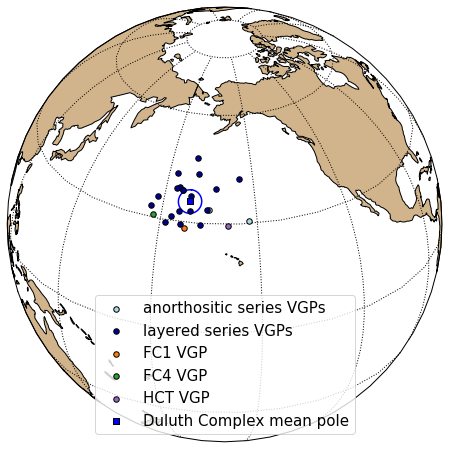

In [73]:
map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=30)
ipmag.plot_vgp(map_axis,vgp_lon=Beck_Anorthositic_filtered.vgp_lon,
               vgp_lat=Beck_Anorthositic_filtered.vgp_lat,color='lightblue',
               label='anorthositic series VGPs',markersize=30)
ipmag.plot_vgp(map_axis,vgp_lon=Beck_Layered_filtered.vgp_lon,
               vgp_lat=Beck_Layered_filtered.vgp_lat,color='darkblue',
               label='layered series VGPs',markersize=30)
ipmag.plot_vgp(map_axis,vgp_lon=FC1_thermal.vgp_lon.tolist()[0],
               vgp_lat=FC1_thermal.vgp_lat.tolist()[0],color='C1',
               label='FC1 VGP',markersize=30)
ipmag.plot_vgp(map_axis,vgp_lon=FC4_AF.vgp_lon.tolist()[0],
               vgp_lat=FC4_AF.vgp_lat.tolist()[0],color='C2',
               label='FC4 VGP',markersize=30)
ipmag.plot_vgp(map_axis,vgp_lon=HCT_thermal.vgp_lon.tolist()[0],
               vgp_lat=HCT_thermal.vgp_lat.tolist()[0],color='C4',
               label='HCT VGP',markersize=30)

layered_lons = Beck_Layered_filtered.vgp_lon.tolist()
layered_lats = Beck_Layered_filtered.vgp_lat.tolist()
anorthositic_lons = Beck_Anorthositic_filtered.vgp_lon.tolist()
anorthositic_lats = Beck_Anorthositic_filtered.vgp_lat.tolist()
new_vgp_lons = HCT_thermal.vgp_lon.tolist() + FC4_AF.vgp_lon.tolist() + FC1_thermal.vgp_lon.tolist()
new_vgp_lats = HCT_thermal.vgp_lat.tolist() + FC4_AF.vgp_lat.tolist() + FC1_thermal.vgp_lat.tolist()

Duluth_Complex_pole = ipmag.fisher_mean(layered_lons+anorthositic_lons+new_vgp_lons,
                                     layered_lats+anorthositic_lats+new_vgp_lats)
ipmag.plot_pole(map_axis,Duluth_Complex_pole['dec'],Duluth_Complex_pole['inc'],Duluth_Complex_pole['alpha95'], 
                color ='blue', marker='s',
                label = 'Duluth Complex mean pole',markersize=40)

plt.legend(loc=8, scatterpoints=1, fontsize=15)
plt.savefig('./code_output/Duluth_complex_VGPs.pdf')
plt.show()

In [74]:
ipmag.print_pole_mean(Duluth_Complex_pole)

Plon: 188.7  Plat: 35.6
Number of directions in mean (n): 24
Angular radius of 95% confidence (A_95): 3.1
Precision parameter (k) estimate: 91.1


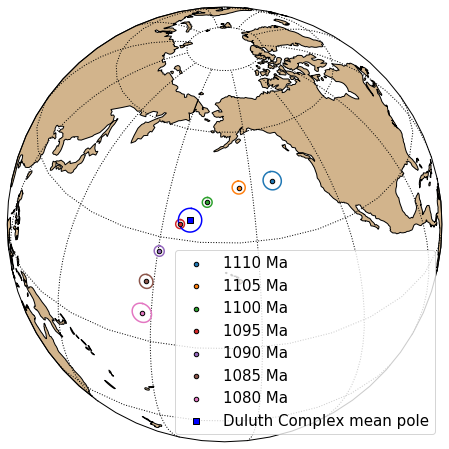

In [75]:
one_Euler_pole_lon = np.loadtxt('../data/mcplates_results/pole_lon_positions1.txt')
one_Euler_pole_lat = np.loadtxt('../data/mcplates_results/pole_lat_positions1.txt')

m = ipmag.make_orthographic_map(central_latitude=35,central_longitude=200)

fisher0 = ipmag.fisher_mean(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
theta0 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
fisher0['theta'] = theta0
ipmag.plot_pole(m,fisher0['dec'],fisher0['inc'],theta0,color='C0',label='1110 Ma')

fisher1 = ipmag.fisher_mean(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
theta1 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
fisher1['theta'] = theta1
ipmag.plot_pole(m,fisher1['dec'],fisher1['inc'],theta1,color='C1',label='1105 Ma')

fisher2 = ipmag.fisher_mean(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
theta2 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
fisher2['theta'] = theta2
ipmag.plot_pole(m,fisher2['dec'],fisher2['inc'],theta2,color='C2',label='1100 Ma')

fisher3 = ipmag.fisher_mean(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
theta3 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
fisher3['theta'] = theta3
ipmag.plot_pole(m,fisher3['dec'],fisher3['inc'],theta3,color='C3',label='1095 Ma')

fisher4 = ipmag.fisher_mean(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
theta4 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
fisher4['theta'] = theta4
ipmag.plot_pole(m,fisher4['dec'],fisher4['inc'],theta4,color='C4',label='1090 Ma')

fisher5 = ipmag.fisher_mean(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
theta5 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
fisher5['theta'] = theta5
ipmag.plot_pole(m,fisher5['dec'],fisher5['inc'],theta5,color='C5',label='1085 Ma')

fisher6 = ipmag.fisher_mean(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
theta6 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
fisher6['theta'] = theta6
ipmag.plot_pole(m,fisher6['dec'],fisher6['inc'],theta6,color='C6',label='1080 Ma')

ipmag.plot_pole(m,Duluth_Complex_pole['dec'],Duluth_Complex_pole['inc'],Duluth_Complex_pole['alpha95'], 
                color ='blue', marker='s', label = 'Duluth Complex mean pole',markersize=30)
plt.legend(loc=4, fontsize=15)
plt.savefig('./code_output/Duluth_Complex_Euler_Path.pdf')
plt.show()

In [76]:
Duluth_lat = 46.79
Duluth_lon = -92.10

print('Duluth paleolatitude at 1110 Ma (1 Euler inversion):')
print(ipmag.lat_from_pole(Duluth_lon, Duluth_lat, fisher0['dec'], fisher0['inc']))
print('')
print('Duluth paleolatitude at 1105 Ma (1 Euler inversion):')
print(ipmag.lat_from_pole(Duluth_lon, Duluth_lat, fisher1['dec'], fisher1['inc']))
print('')
print('Duluth paleolatitude at 1100 Ma (1 Euler inversion):')
print(ipmag.lat_from_pole(Duluth_lon, Duluth_lat, fisher2['dec'], fisher2['inc']))
print('')
print('Duluth paleolatitude at 1095 Ma (1 Euler inversion):')
print(ipmag.lat_from_pole(Duluth_lon, Duluth_lat, fisher3['dec'], fisher3['inc']))
print('')
print('Duluth paleolatitude implied by Duluth Complex pole:')
print(ipmag.lat_from_pole(Duluth_lon, Duluth_lat, Duluth_Complex_pole['dec'],Duluth_Complex_pole['inc']))

Duluth paleolatitude at 1110 Ma (1 Euler inversion):
56.087281584905

Duluth paleolatitude at 1105 Ma (1 Euler inversion):
47.36765244697051

Duluth paleolatitude at 1100 Ma (1 Euler inversion):
38.19752912645617

Duluth paleolatitude at 1095 Ma (1 Euler inversion):
29.094926428672316

Duluth paleolatitude implied by Duluth Complex pole:
31.903681735535827


In [77]:
North_Shore

,site,location,samples,specimens,dir_alpha95,dir_comp_name,dir_dec,dir_inc,dir_k,dir_n_samples,dir_n_specimens,dir_n_specimens_lines,dir_n_specimens_planes,dir_polarity,dir_r,dir_tilt_correction,lat,lon,analysts,criteria,software_packages,citations,method_codes,result_quality,dec_tc,inc_tc,paleolatitude,vgp_lat,vgp_lon,vgp_lat_rev,vgp_lon_rev
2,FC1,North,FC1-1:FC1-2:FC1-3:FC1-4:FC1-5:FC1-6:FC1-7:FC1-...,FC1-1a:FC1-2a:FC1-3a:FC1-4a:FC1-5a:FC1-6a:FC1-...,9.3,mc,301.6,40.5,32,9,9,9,0,NaN,8.7489,0,47.7826,-91.3265,Yiming Zhang,ACCEPT,pmagpy-4.2.25: demag_gui.v.3.0,This study,LP-DIR-AF:DE-BFL:DA-DIR-GEO:LP-DC4:DE-FM,g,297.134482,52.385273,32.980271,41.316929,184.974390,-41.316929,4.974390
3,FC1,North,FC1-1:FC1-2:FC1-3:FC1-4:FC1-5:FC1-6:FC1-7:FC1-...,FC1-1b:FC1-2b:FC1-3b:FC1-4b:FC1-5b:FC1-6b:FC1-...,6.5,mt,289.7,34.4,64,9,9,9,0,NaN,8.8741,0,47.7826,-91.3265,Yiming Zhang,ACCEPT,pmagpy-4.2.25: demag_gui.v.3.0,This study,LP-DIR-T:DE-BFL:DA-DIR-GEO:LP-DC4:DE-FM,g,284.110929,45.103706,26.648106,28.593061,187.847898,-28.593061,7.847898
6,FC4,North,FC4-1:FC4-2:FC4-3:FC4-6:FC4-7:FC4-8:FC4-9,FC4-1a:FC4-2a:FC4-3a:FC4-6a:FC4-7a:FC4-8a:FC4-9a,7.9,mc,296.0,26.8,59,7,7,7,0,NaN,6.8977,0,47.7625,-91.3827,NaN,ACCEPT,pmagpy-4.2.25: demag_gui.v.3.0,This study,LP-DIR-AF:DE-BFL:DA-DIR-GEO:LP-DC4:DE-FM,g,292.632873,38.265560,21.523703,30.815285,177.388326,-30.815285,357.388326
9,HCT1,North,HCT1-1:HCT1-2:HCT1-3:HCT1-5:HCT1-6:HCT1-7:HCT1-8,HCT1-1a:HCT1-2a:HCT1-3a:HCT1-5a:HCT1-6a:HCT1-7...,8.3,mc,287.2,35.6,54,7,7,7,0,NaN,6.8893,0,47.6008,-91.1495,Yiming Zhang,ACCEPT,pmagpy-4.2.25: demag_gui.v.3.0,This study,LP-DIR-AF:DE-BFL:DA-DIR-GEO:LP-DC4:DE-FM,g,280.953111,45.964685,27.344701,26.937064,190.833620,-26.937064,10.833620
10,HCT1,North,HCT1-1:HCT1-2:HCT1-3:HCT1-5:HCT1-6:HCT1-8,HCT1-1b:HCT1-2b:HCT1-3b:HCT1-5b:HCT1-6b:HCT1-8b,5.6,mt,285.7,45.3,144,6,6,6,0,NaN,5.9652,0,47.6008,-91.1495,Yiming Zhang,ACCEPT,pmagpy-4.2.25: demag_gui.v.3.0,This study,LP-DIR-T:DE-BFL:DA-DIR-GEO:LP-DC4:DE-FM,g,276.317559,55.283566,35.816076,29.492268,201.037076,-29.492268,21.037076


In [78]:
North_Shore.to_latex(columns=['site', 'lat', 'lon','dir_n_samples','dir_dec','dir_inc','dec_tc','inc_tc','dir_k','dir_alpha95','vgp_lat','vgp_lon'])

'\\begin{tabular}{llrrrrrrrrrrr}\n\\toprule\n{} &  site &      lat &      lon &  dir\\_n\\_samples &  dir\\_dec &  dir\\_inc &      dec\\_tc &     inc\\_tc &  dir\\_k &  dir\\_alpha95 &    vgp\\_lat &     vgp\\_lon \\\\\n\\midrule\n2  &   FC1 &  47.7826 & -91.3265 &              9 &    301.6 &     40.5 &  297.134482 &  52.385273 &     32 &          9.3 &  41.316929 &  184.974390 \\\\\n3  &   FC1 &  47.7826 & -91.3265 &              9 &    289.7 &     34.4 &  284.110929 &  45.103706 &     64 &          6.5 &  28.593061 &  187.847898 \\\\\n6  &   FC4 &  47.7625 & -91.3827 &              7 &    296.0 &     26.8 &  292.632873 &  38.265560 &     59 &          7.9 &  30.815285 &  177.388326 \\\\\n9  &  HCT1 &  47.6008 & -91.1495 &              7 &    287.2 &     35.6 &  280.953111 &  45.964685 &     54 &          8.3 &  26.937064 &  190.833620 \\\\\n10 &  HCT1 &  47.6008 & -91.1495 &              6 &    285.7 &     45.3 &  276.317559 &  55.283566 &    144 &          5.6 &  29.492268 &  201.0

In [80]:
#North_Shore.to_excel('./code_output/North_Shore_Data.xls',columns=['site', 'lat', 'lon','dir_n_samples','dir_dec','dir_inc','dec_tc','inc_tc','dir_k','dir_alpha95','vgp_lat','vgp_lon'])
#Beck_Anorthositic_series_tilt_corrected.to_excel('./code_output/Beck_anorthosite.xls',columns=['site', 'lat', 'lon','dir_n_samples','dir_dec','dir_inc','dec_tc','inc_tc','dir_k','dir_alpha95','vgp_lat','vgp_lon'])
#Beck_Layered_series_tilt_corrected.to_excel('./code_output/Beck_layered.xls',columns=['site', 'lat', 'lon','dir_n_samples','dir_dec','dir_inc','dec_tc','inc_tc','dir_k','dir_alpha95','vgp_lat','vgp_lon'])

# Duluth Complex area

The area of the Duluth Complex can be calculated from the polygons of the S21 MN Geological map.

In [82]:
MN_geo_polygons = pd.read_csv('../data/geology/MN_geology_polygons.csv')
MN_geo_polygons.head()

,AREA,PERIMETER,TYPE,GCM_CODE,GEOC_SRC,GEOC_DATE,UTME,UTMN,UTM_ZONE,MAPLABEL,DESCRIPTN,UNIT_NAME,TERRANE,ERA,SUBDIV,AREA_CALC
0,1.055855e+06,5101.682095,BG,AB,MGS,20101215,344100,5471393,15,Amv,Mafic metavolcanic rocks; minor volcaniclastic...,NaN,Wabigoon subprovince,Neoarchean,Superior Province,1056082.0
1,4.058488e+06,8978.228037,BG,AB,MGS,20101215,344483,5470243,15,Asd,"Syenitic, monzodioritic, or dioritic pluton",NaN,massive to weakly foliated,Neoarchean,Superior Province,4059328.0
2,5.945258e+07,63606.085456,BG,AB,MGS,20101215,353379,5466664,15,Agr,Granitic intrusion,NaN,massive to weakly foliated,Neoarchean,Superior Province,59467613.0
3,7.830187e+06,23317.507491,BG,AB,MGS,20101215,355501,5469271,15,Amv,Mafic metavolcanic rocks; minor volcaniclastic...,NaN,Wabigoon subprovince,Neoarchean,Superior Province,7832350.0
4,2.492758e+07,50540.399729,BG,AB,MGS,20101215,353660,5465002,15,Avs,Volcanic and volcaniclastic rocks; felsic to i...,NaN,Wabigoon subprovince,Neoarchean,Superior Province,24934273.0


In [83]:
anortho_polygons = MN_geo_polygons[MN_geo_polygons.MAPLABEL == "Mau"]
layered_polygons = MN_geo_polygons[(MN_geo_polygons.MAPLABEL == "Mlc") | (MN_geo_polygons.MAPLABEL == "Mlf") | 
                                   (MN_geo_polygons.MAPLABEL == "Mlg") | (MN_geo_polygons.MAPLABEL == "Mlt")]
early_gabbro_polygons = MN_geo_polygons[MN_geo_polygons.MAPLABEL == "Mge"]
felsic_series_polygons = MN_geo_polygons[MN_geo_polygons.MAPLABEL == "Mfg"]
HCT_polygons = MN_geo_polygons[(MN_geo_polygons.MAPLABEL == "Mbt")]
BBC_polygons = MN_geo_polygons[(MN_geo_polygons.MAPLABEL == "Mbd") | (MN_geo_polygons.MAPLABEL == "Mbf")|
                                (MN_geo_polygons.MAPLABEL == "Mbg")]

Calculate the area in square kilometers

In [84]:
anorthositic_area = anortho_polygons.AREA.sum()/(1000*1000)
anorthositic_area

2312.0925388010287

In [85]:
layered_area = layered_polygons.AREA.sum()/(1000*1000)
layered_area

2568.5970853061776

In [86]:
early_gabbro_area = early_gabbro_polygons.AREA.sum()/(1000*1000)
early_gabbro_area

260.0774290471

In [87]:
felsic_series_area = felsic_series_polygons.AREA.sum()/(1000*1000)
felsic_series_area

490.84322160180295

In [88]:
anorthositic_area + layered_area + early_gabbro_area + felsic_series_area

5631.610274756109

In [89]:
HCT_area = HCT_polygons.AREA.sum()/(1000*1000)
HCT_area

150.190668502

In [90]:
BBC_area = BBC_polygons.AREA.sum()/(1000*1000)
BBC_area

1035.8102578461144

In [91]:
Duluth_Complex_strike_length = 220
Duluth_Complex_surface_width = 100
Duluth_Complex_dip = 20
Duluth_Complex_as_the_crow_flies = 30

Duluth_Complex_width = Duluth_Complex_surface_width/np.cos(np.deg2rad(Duluth_Complex_dip))
Duluth_Complex_thickness = np.sin(np.deg2rad(Duluth_Complex_dip))*Duluth_Complex_as_the_crow_flies
Duluth_Complex_thickness

10.260604299770062

In [92]:
Duluth_Complex_volume = Duluth_Complex_width*Duluth_Complex_thickness*Duluth_Complex_strike_length
Duluth_Complex_volume

240220.35461569353